In [1]:
#########################################
#Energy Storage Optimization
#April 2018; Updated May 2019
#Updated April 2021
#Author: Suman Gautam, AK

#This code is used to predict the future real-time LMPs. 
#This is done in two-folds.
#1) estimating historical relationship between real-time and day-ahead
#   lmps, using simple linear regression analysis. 
#2) The residuals from regression analysis are used to quantify the 
#   stochastic nature observed in the real-time market. 

In [165]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from sklearn import preprocessing as sk
from sklearn.linear_model import LinearRegression
import scipy
import random
import warnings
warnings.simplefilter("ignore")

import statsmodels.api as ssm
import glob
import os

In [166]:
dfIn1 = pd.read_excel('Price History.xlsx',sheet_name='Ramapo DA',skiprows=0)

In [167]:
dfIn2 = pd.read_excel('Price History.xlsx',sheet_name='Ramapo RT',skiprows=0)

In [40]:
# dfIn1 = dfIn1[dfIn1['Gen Name']=='DUNKIRK___1']

In [44]:
dfIn1['Datetime'] = pd.to_datetime(dfIn1['Eastern Date Hour'])
dfIn2['Datetime'] = pd.to_datetime(dfIn2['RTD End Time Stamp'])

In [51]:
dfIn2

,Gen PTID,RTD Gen LBMP,RTD Gen Losses,RTD Gen Congestion,RTD Gen Price Version
Datetime,,,,,
2016-01-01 00:00:00,23563.0,-5.767273,0.677273,-13.664545,1.0
2016-01-01 01:00:00,23563.0,3.743333,0.218333,-12.004167,1.0
2016-01-01 02:00:00,23563.0,1.198333,0.055833,-3.733333,1.0
2016-01-01 03:00:00,23563.0,-0.334167,0.035000,-1.788333,1.0
2016-01-01 04:00:00,23563.0,2.857500,-0.054167,-0.145833,1.0
...,...,...,...,...,...
2021-07-27 03:00:00,23563.0,21.042500,0.640000,-1.613333,1.0
2021-07-27 04:00:00,23563.0,16.972500,0.425833,-2.546667,1.0
2021-07-27 05:00:00,23563.0,17.860833,0.510000,-2.895000,1.0


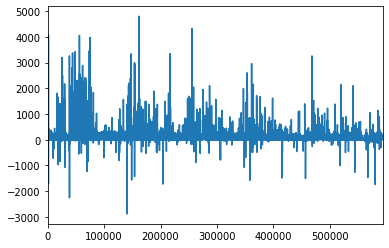

In [23]:
dfIn2['RTD Gen LBMP'].plot()

In [46]:
dfIn2 = dfIn2.set_index('Datetime').resample('H').mean()

dfIn1.index = dfIn1['Datetime']

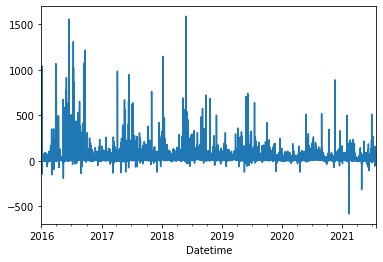

In [47]:
dfIn2['RTD Gen LBMP'].plot()

In [73]:
dfIn1['RTD Gen LBMP'] = dfIn2['RTD Gen LBMP']
dfIn1['RTD Gen Congestion'] = dfIn2['RTD Gen Congestion']
dfIn1['RTD Gen Losses'] = dfIn2['RTD Gen Losses']


In [ ]:
# for i in range(len(dfIn1)):
    
#     try:
        
#         if dfIn1.index[i] == dfIn2.index[i]:
#             dfIn1['RTD Gen LBMP'].values[i] = dfIn2['RTD Gen LBMP'].values[i]
            
#             dfIn1['RTD Gen Congestion'].values[i] = dfIn2['RTD Gen Congestion'].values[i]
#             dfIn1['RTD Gen Losses'].values[i] = dfIn2['RTD Gen Losses'].values[i]
#     except:
        
#         continue
        

In [74]:
dfIn1.to_excel('Dunkirk1.xlsx')

In [109]:
dfIn = dfIn1
dfIn = dfIn.dropna()

In [110]:
dfloads

,Transaction Dates (Calculated),Hour Beginning,Transaction Dates,West - A Day Ahead Forecast Load,West - A Actual Load,Datetime
Datetime,,,,,,
2016-01-01 00:00:00,2016-01-01 00:00:00,0,2016-01-01 05:00:00,1598,1603.3,2016-01-01 00:00:00
2016-01-01 01:00:00,2016-01-01 01:00:00,1,2016-01-01 06:00:00,1528,1536,2016-01-01 01:00:00
2016-01-01 02:00:00,2016-01-01 02:00:00,2,2016-01-01 07:00:00,1481,1480.4,2016-01-01 02:00:00
2016-01-01 03:00:00,2016-01-01 03:00:00,3,2016-01-01 08:00:00,1456,1459.6,2016-01-01 03:00:00
2016-01-01 04:00:00,2016-01-01 04:00:00,4,2016-01-01 09:00:00,1438,1454.8,2016-01-01 04:00:00
...,...,...,...,...,...,...
2021-08-08 20:00:00,2021-08-08 20:00:00,20,2021-08-09 01:00:00,2021,2111.54,2021-08-08 20:00:00
2021-08-08 21:00:00,2021-08-08 21:00:00,21,2021-08-09 02:00:00,1918,2012.16,2021-08-08 21:00:00
2021-08-08 22:00:00,2021-08-08 22:00:00,22,2021-08-09 03:00:00,1802,1890.14,2021-08-08 22:00:00


In [82]:
dfloads = pd.read_excel('Price History.xlsx',sheet_name='Loads',skiprows=0)
dfloads['Datetime'] = pd.to_datetime(dfloads['Transaction Dates (Calculated)'])
dfloads.index = dfloads['Datetime']


In [111]:
dfIn['West - A Day Ahead Forecast Load'] = dfloads['West - A Day Ahead Forecast Load']
dfIn['West - A Actual Load'] = dfloads['West - A Actual Load']

In [112]:
dfIn

,Eastern Date Hour,Gen Name,Gen PTID,DAM Gen LBMP,DAM Gen Losses,DAM Gen Congestion,DAM Gen Price Version,Datetime,RTD Gen LBMP,RTD Gen Congestion,RTD Gen Losses,West - A Day Ahead Forecast Load,West - A Actual Load
Datetime,,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01 00:00:00,DUNKIRK___1,23563,13.47,0.26,-2.44,1,2016-01-01 00:00:00,-5.767273,-13.664545,0.677273,1598,1603.3
2016-01-01 01:00:00,2016-01-01 01:00:00,DUNKIRK___1,23563,12.39,0.30,-1.89,1,2016-01-01 01:00:00,3.743333,-12.004167,0.218333,1528,1536
2016-01-01 02:00:00,2016-01-01 02:00:00,DUNKIRK___1,23563,11.22,0.32,-1.44,1,2016-01-01 02:00:00,1.198333,-3.733333,0.055833,1481,1480.4
2016-01-01 03:00:00,2016-01-01 03:00:00,DUNKIRK___1,23563,11.46,0.32,-1.39,1,2016-01-01 03:00:00,-0.334167,-1.788333,0.035000,1456,1459.6
2016-01-01 04:00:00,2016-01-01 04:00:00,DUNKIRK___1,23563,10.70,0.30,-1.72,1,2016-01-01 04:00:00,2.857500,-0.145833,-0.054167,1438,1454.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-27 03:00:00,2021-07-27 03:00:00,DUNKIRK___1,23563,22.06,0.95,-1.64,1,2021-07-27 03:00:00,21.042500,-1.613333,0.640000,1529,1573.38
2021-07-27 04:00:00,2021-07-27 04:00:00,DUNKIRK___1,23563,22.31,1.05,-1.44,1,2021-07-27 04:00:00,16.972500,-2.546667,0.425833,1573,1615.9
2021-07-27 05:00:00,2021-07-27 05:00:00,DUNKIRK___1,23563,23.98,1.27,-1.23,1,2021-07-27 05:00:00,17.860833,-2.895000,0.510000,1631,1682.66


In [113]:
dfIn.columns

Index(['Eastern Date Hour', 'Gen Name', 'Gen PTID', 'DAM Gen LBMP',
       'DAM Gen Losses', 'DAM Gen Congestion', 'DAM Gen Price Version',
       'Datetime', 'RTD Gen LBMP', 'RTD Gen Congestion', 'RTD Gen Losses',
       'West - A Day Ahead Forecast Load', 'West - A Actual Load'],
      dtype='object')

In [114]:
datetime_label = dfIn.columns[0]
da_lmp_label = dfIn.columns[3]
rt_lmp_label = dfIn.columns[8]
da_load_label = dfIn.columns[11]
rt_load_label = dfIn.columns[12]

In [115]:
# idx = pd.date_range('1/1/2016', periods=43849, freq='H')
# dfIn.index = idx

# dfIn.index = dfIn[datetime_label]
# dfIn = dfIn.drop(columns=datetime_label)

dfIn['Month'] = dfIn.index.month


summer = [6,7,8]
winter = [12,1,2]
shoulder = [3,4,5,9,10,11]
all_year = [1,2,3,4,5,6,7,8,9,10,11,12]

dfIn['Summer'] = 0
dfIn['Winter'] = 0
dfIn['Shoulder'] = 0


dfIn['Summer'][dfIn.index.month.isin(summer)] = 1
dfIn['Winter'][dfIn.index.month.isin(winter)] = 1
dfIn['Shoulder'][dfIn.index.month.isin(shoulder)] = 1

In [ ]:
dfIn['West - A Actual Load'][25192] = 1675

In [159]:
df_train = dfIn[(dfIn.index.year<2021)&(dfIn.index.year>2015)]
df_test  = dfIn[dfIn.index.year>=2021]

In [160]:
df_train[rt_lmp_label] = pd.to_numeric(df_train[rt_lmp_label])
df_train[da_lmp_label] = pd.to_numeric(df_train[da_lmp_label])


df_train['Difference'] = df_train[rt_lmp_label] - df_train[da_lmp_label]

# Correlation Matrix

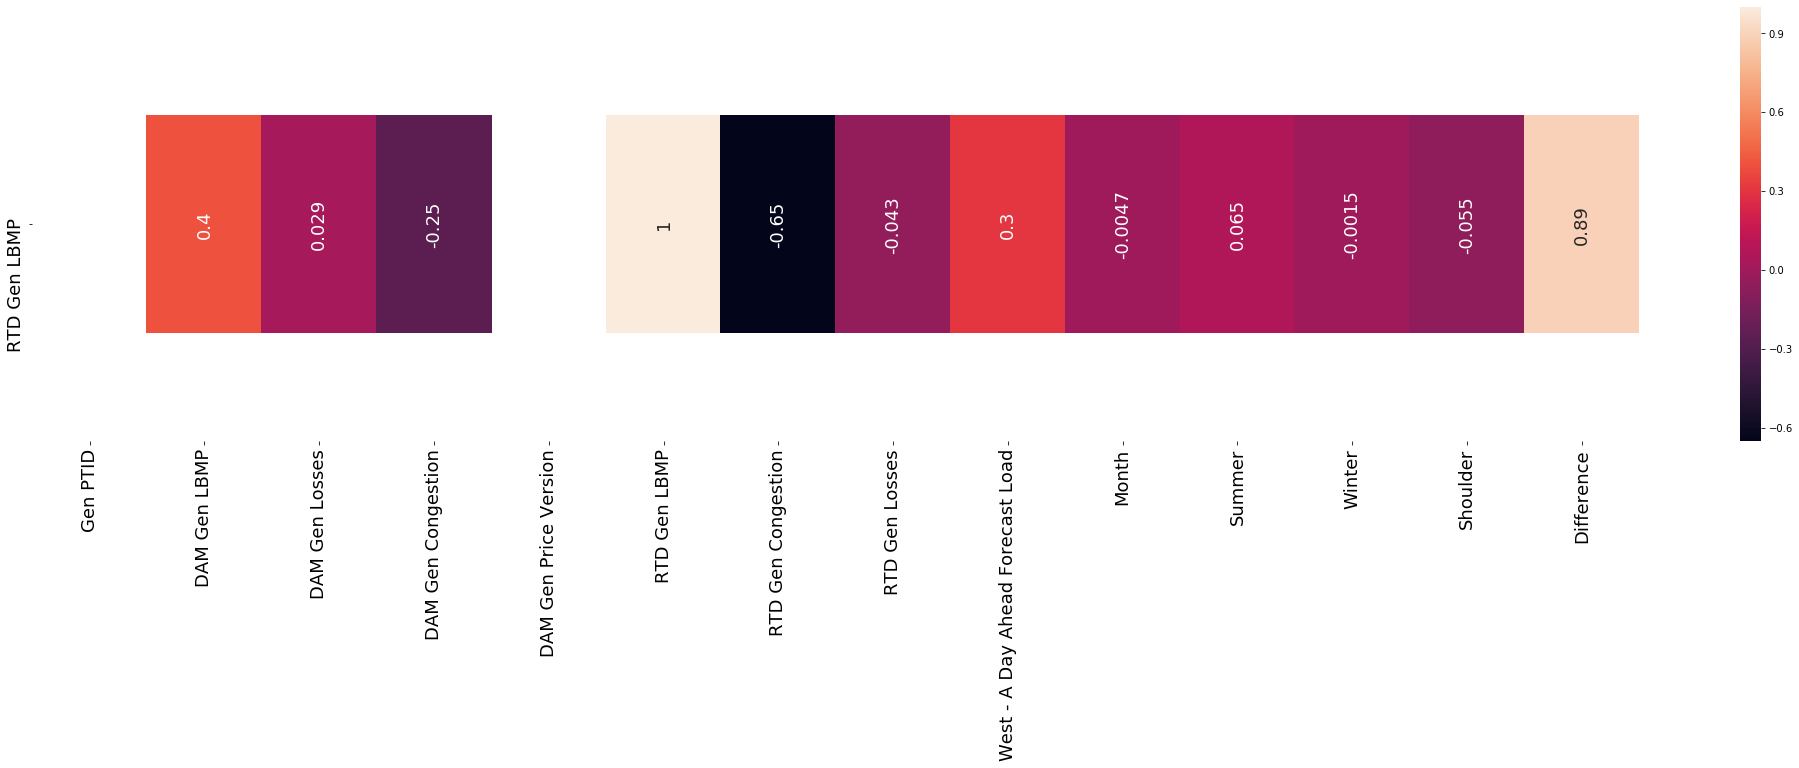

In [118]:
import seaborn as sns


corrMatrix = df_train.corr()
corrMatrix = corrMatrix[corrMatrix.index == rt_lmp_label]

plt.figure(figsize = (36,8))    
ax = sns.heatmap(corrMatrix, annot=True, annot_kws={"size":18,'rotation': 90} )

ax.set_yticklabels(ax.get_yticklabels(), rotation = 90, fontsize = 18)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90,fontsize = 18)


bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

# Check for Multi collinearity

In [128]:
df_train[da_lmp_label] = pd.to_numeric(df_train[da_lmp_label])
df_train[rt_lmp_label] = pd.to_numeric(df_train[rt_lmp_label])

df_train[da_load_label] = pd.to_numeric(df_train[da_load_label])
df_train[rt_load_label] = pd.to_numeric(df_train[rt_load_label])



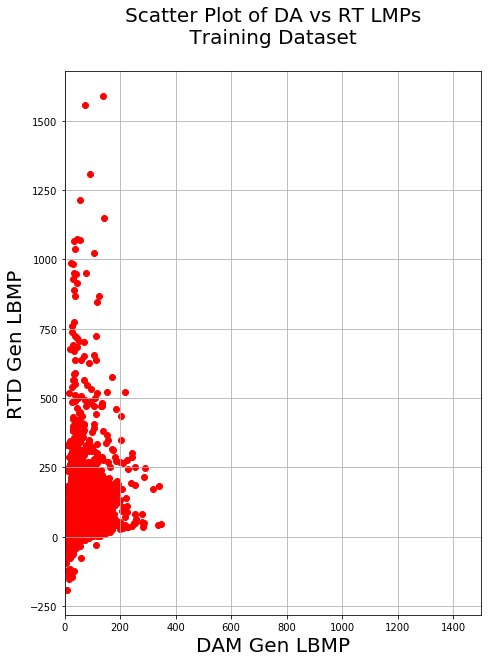

In [163]:
x = df_train[da_lmp_label]
y = df_train[rt_lmp_label]

fig = plt.figure(figsize=(10, 10))

# plt.hist(dfLMP['DA LMP'],label='Real' +'DA LMP'+ ' distribution',alpha=0.5,density=True,color='b')

# plt.hist(dfModel['RT Gen MW'],label='Monte RT Gen MW',alpha=0.5,density=True,color='r')
# plt.legend(loc='upper right')
plt.xlabel(da_lmp_label,fontsize = 20)
plt.ylabel(rt_lmp_label, fontsize = 20)

plt.xlim(0, 1500)
# plt.ylim(0, 600)
plt.gca().set_aspect('equal', adjustable='box')

plt.title('Scatter Plot of DA vs RT LMPs\n Training Dataset \n' ,fontdict = {'fontsize' : 20})
plt.grid(True)

plt.scatter(x,y,color='red')

# Weed out the outliers

In [143]:
input_array = df_train[[da_lmp_label]]
output_array = df_train[[rt_lmp_label]]

input_array = ssm.add_constant(input_array)

model0= ssm.OLS(output_array,input_array).fit() 

preds0 = model0.predict(input_array)
op = [item for sublist in output_array.values for item in sublist]
residuals0 = op - preds0.values

# with open('summary_model1.csv', 'w') as fh:
#     fh.write(model1.summary().as_csv())
    
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           RTD Gen LBMP   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     8354.
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        09:51:29   Log-Likelihood:            -2.2230e+05
No. Observations:               43841   AIC:                         4.446e+05
Df Residuals:                   43839   BIC:                         4.446e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.1600      0.312     13.327      0.000       3.548       4.772
DAM Gen LBMP     0.8597      0.009     91.398      0.000       0.841       0.878
==============================================================================
Omnibus:                    81453.243   Durbin-Watson:                   1.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        197120554.494
Skew:                          13.929   Prob(JB):                         0.00
Kurtosis:                     330.314   Cond. No.                         56.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
outliers = []
for i in range(len(residuals0)):
    
    if abs(residuals0[i]) > np.percentile(abs(residuals0), 99.5):
        outliers.append(i)
        print(residuals0[i])
    

298.4421066966246
1001.5539021040026
530.0352804660993
899.2434256173657
267.688551604568
314.5239291185682
227.31336418702173
215.36796515145102
239.68372690476713
223.36281079508453
348.8648924888769
832.2977968699234
453.6532260516224
1033.3047359763705
916.4664171425708
950.3545645055068
308.1637680402517
295.8114528635874
352.8290864107397
456.71873812353573
512.2126649230484
251.30329687441073
369.7452926025172
232.9849539281953
334.1157049681232
317.5685987255271
359.33257410043956
376.36714140856344
246.8152482403022
244.81851904876854
639.4856168014253
402.36955693658194
195.316735399194
376.19339034171185
290.46405004804166
302.8888406534659
426.1552524777933
343.3062412679992
653.2131654833977
-203.8822666582253
393.7925890812341
552.0117413173593
421.80345978802615
320.6823321051916
741.4467466628353
299.65295127116286
318.14901790619416
872.8020599862518
250.18042027637702
602.510340139111
319.84809388094413
277.2057861834589
240.64537755744252
324.8996211271659
368.767160

In [145]:
df_train['Outlier'] = 0

for i in range(len(df_train)):
    
    if i in outliers:
        df_train['Outlier'].iloc[i] = 1

df_outliers = df_train[df_train['Outlier']==1]

df_train[rt_lmp_label][df_train['Outlier']==1] = df_train[da_lmp_label] 

In [146]:
df_outliers

,Eastern Date Hour,Gen Name,Gen PTID,DAM Gen LBMP,DAM Gen Losses,DAM Gen Congestion,DAM Gen Price Version,Datetime,RTD Gen LBMP,RTD Gen Congestion,RTD Gen Losses,West - A Day Ahead Forecast Load,West - A Actual Load,Month,Summer,Winter,Shoulder,Difference,Outlier
Datetime,,,,,,,,,,,,,,,,,,,
2016-01-04 21:00:00,2016-01-04 21:00:00,DUNKIRK___1,23563,38.65,-1.35,-0.39,1,2016-01-04 21:00:00,335.828333,0.000000,-19.039167,2068,2118,1,0,1,0,297.178333,1
2016-01-05 08:00:00,2016-01-05 08:00:00,DUNKIRK___1,23563,37.68,-1.44,10.61,1,2016-01-05 08:00:00,1038.106250,-224.225625,-14.932500,2025,2106.3,1,0,1,0,1000.426250,1
2016-01-05 09:00:00,2016-01-05 09:00:00,DUNKIRK___1,23563,34.66,-1.33,9.94,1,2016-01-05 09:00:00,563.991429,222.412857,-48.940000,2027,2103,1,0,1,0,529.331429,1
2016-01-05 10:00:00,2016-01-05 10:00:00,DUNKIRK___1,23563,31.36,-0.88,6.28,1,2016-01-05 10:00:00,930.362667,0.000000,-54.220667,2030,2123.8,1,0,1,0,899.002667,1
2016-03-02 18:00:00,2016-03-02 18:00:00,DUNKIRK___1,23563,87.80,0.75,-60.25,1,2016-03-02 18:00:00,347.327500,-286.842500,-0.776667,2030,2074.3,3,0,0,1,259.527500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-10 13:00:00,2020-07-10 13:00:00,DUNKIRK___1,23563,71.66,2.83,-43.33,1,2020-07-10 13:00:00,261.797857,-230.461429,3.124286,2493,2659.6,7,1,0,0,190.137857,1
2020-08-29 09:00:00,2020-08-29 09:00:00,DUNKIRK___1,23563,15.80,-0.35,-0.42,1,2020-08-29 09:00:00,518.288095,-493.438571,-0.335714,1762,1751.61,8,1,0,0,502.488095,1
2020-10-13 08:00:00,2020-10-13 08:00:00,DUNKIRK___1,23563,17.84,-0.34,-3.32,1,2020-10-13 08:00:00,345.377143,-162.897857,0.025000,1565,1580.93,10,0,0,1,327.537143,1


# Train

In [147]:
df_train['Hour Beginning'] = df_train.index.hour
df_test['Hour Beginning'] = df_test.index.hour


In [148]:
# df_train['log month'] = np.log(df_train['Month'])
# df_train['log hour'] = np.log(df_train['Hour Beginning'])

# df_train['log hour'][df_train['Hour Beginning']==0] = 0

In [149]:
df_train['Hour Beginning'] = pd.to_numeric(df_train['Hour Beginning'])
df_test['Hour Beginning'] = pd.to_numeric(df_test['Hour Beginning'])

In [150]:
df_train = df_train.fillna(0)

In [153]:
input_array = df_train[[da_lmp_label]]
output_array = df_train[[rt_lmp_label]]


input_array = ssm.add_constant(input_array)

model1= ssm.OLS(output_array,input_array).fit() 

preds1 = model1.predict(input_array)
op = [item for sublist in output_array.values for item in sublist]
residuals1 = op - preds1.values

# with open('summary_model1.csv', 'w') as fh:
#     fh.write(model1.summary().as_csv())
    
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           RTD Gen LBMP   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                 2.084e+04
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        09:53:50   Log-Likelihood:            -1.9427e+05
No. Observations:               43841   AIC:                         3.885e+05
Df Residuals:                   43839   BIC:                         3.886e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.1011      0.165     37.048      0.000       5.778       6.424
DAM Gen LBMP     0.7164      0.005    144.368      0.000       0.707       0.726
==============================================================================
Omnibus:                    32279.532   Durbin-Watson:                   1.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1134446.193
Skew:                           3.172   Prob(JB):                         0.00
Kurtosis:                      27.099   Cond. No.                         56.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
input_array = df_train[['Hour Beginning',da_lmp_label]]
output_array = df_train[[rt_lmp_label]]


input_array = ssm.add_constant(input_array)

model1= ssm.OLS(output_array,input_array).fit() 

preds1 = model1.predict(input_array)
op = [item for sublist in output_array.values for item in sublist]
residuals1 = op - preds1.values

# with open('summary_model1.csv', 'w') as fh:
#     fh.write(model1.summary().as_csv())
    
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           RTD Gen LBMP   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                 1.045e+04
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        09:55:06   Log-Likelihood:            -1.9425e+05
No. Observations:               43841   AIC:                         3.885e+05
Df Residuals:                   43838   BIC:                         3.885e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3070      0.212     25.038      0.000       4.892       5.722
Hour Beginning     0.0859      0.014      5.948      0.000       0.058       0.114
DAM Gen LBMP       0.7092      0.005    138.876      0.000       0.699       0.719
==============================================================================
Omnibus:                    32363.652   Durbin-Watson:                   1.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1138135.424
Skew:                           3.185   Prob(JB):                         0.00
Kurtosis:                      27.134   Cond. No.                         76.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

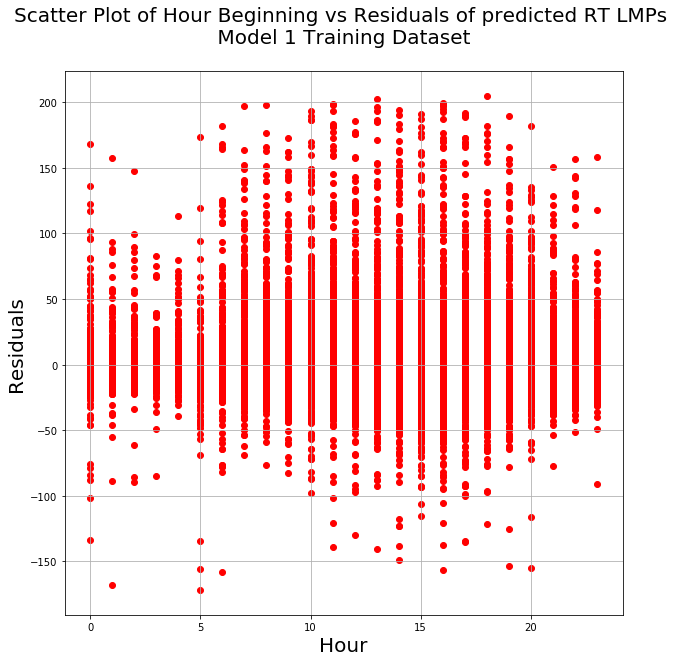

In [152]:
x = df_train['Hour Beginning']
y = residuals1

fig = plt.figure(figsize=(10, 10))

# plt.hist(dfLMP['DA LMP'],label='Real' +'DA LMP'+ ' distribution',alpha=0.5,density=True,color='b')

# plt.hist(dfModel['RT Gen MW'],label='Monte RT Gen MW',alpha=0.5,density=True,color='r')
# plt.legend(loc='upper right')
plt.xlabel('Hour',fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)

# plt.xlim(0, 600)
# plt.ylim(0, 600)
# plt.gca().set_aspect('equal', adjustable='box')

plt.title('Scatter Plot of Hour Beginning vs Residuals of predicted RT LMPs \n Model 1 Training Dataset \n' ,fontdict = {'fontsize' : 20})
plt.grid(True)

plt.scatter(x,y,color='red')

In [155]:
#Best Model

input_array = df_train[[da_lmp_label,'Hour Beginning',da_load_label]]
output_array = df_train[[rt_lmp_label]]

model3= ssm.OLS(output_array,input_array).fit() 


preds3 = model3.predict(input_array)
op = [item for sublist in output_array.values for item in sublist]
residuals3 = op - preds3.values


with open('summary_model3.csv', 'w') as fh:
    fh.write(model3.summary().as_csv())

    
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           RTD Gen LBMP   R-squared (uncentered):                   0.671
Model:                            OLS   Adj. R-squared (uncentered):              0.671
Method:                 Least Squares   F-statistic:                          2.977e+04
Date:                Mon, 09 Aug 2021   Prob (F-statistic):                        0.00
Time:                        09:55:48   Log-Likelihood:                     -1.9417e+05
No. Observations:               43841   AIC:                                  3.883e+05
Df Residuals:                   43838   BIC:                                  3.884e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
DAM Gen LBMP                         0.6734      0.006    119.416      0.000       0.662       0.684
Hour Beginning                       0.0343      0.015      2.288      0.022       0.005       0.064
West - A Day Ahead Forecast Load     0.0041      0.000     28.090      0.000       0.004       0.004
==============================================================================
Omnibus:                    32701.961   Durbin-Watson:                   1.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1152523.792
Skew:                           3.236   Prob(JB):                         0.00
Kurtosis:                      27.270   Cond. No.                         264.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

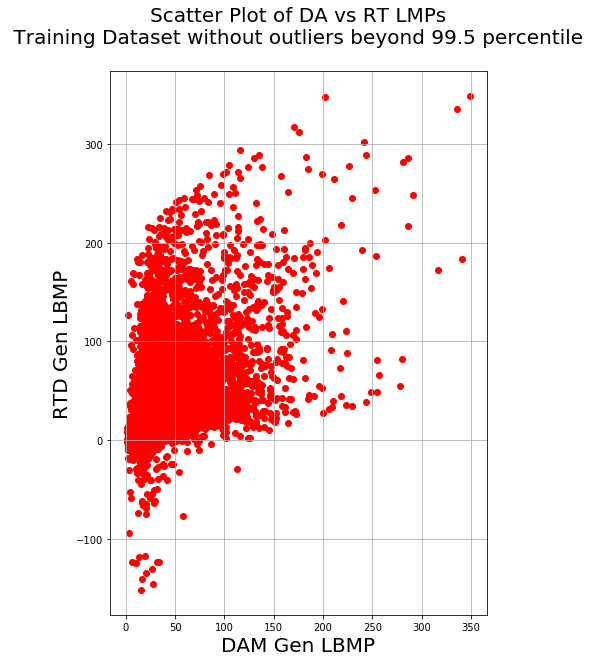

In [156]:
x = df_train[da_lmp_label]
y = df_train[rt_lmp_label]

fig = plt.figure(figsize=(10, 10))

# plt.hist(dfLMP['DA LMP'],label='Real' +'DA LMP'+ ' distribution',alpha=0.5,density=True,color='b')

# plt.hist(dfModel['RT Gen MW'],label='Monte RT Gen MW',alpha=0.5,density=True,color='r')
# plt.legend(loc='upper right')
plt.xlabel(da_lmp_label,fontsize = 20)
plt.ylabel(rt_lmp_label, fontsize = 20)

# plt.xlim(0, 600)
# plt.ylim(0, 600)
plt.gca().set_aspect('equal', adjustable='box')

plt.title('Scatter Plot of DA vs RT LMPs\n Training Dataset without outliers beyond 99.5 percentile \n' ,fontdict = {'fontsize' : 20})
plt.grid(True)

plt.scatter(x,y,color='red')

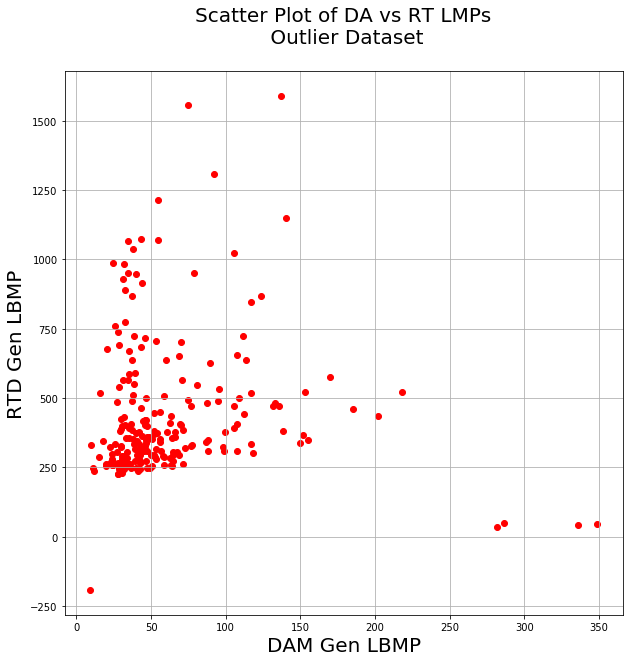

In [157]:
x = df_outliers[da_lmp_label]
y = df_outliers[rt_lmp_label]

fig = plt.figure(figsize=(10, 10))

# plt.hist(dfLMP['DA LMP'],label='Real' +'DA LMP'+ ' distribution',alpha=0.5,density=True,color='b')

# plt.hist(dfModel['RT Gen MW'],label='Monte RT Gen MW',alpha=0.5,density=True,color='r')
# plt.legend(loc='upper right')
plt.xlabel(da_lmp_label,fontsize = 20)
plt.ylabel(rt_lmp_label, fontsize = 20)

# plt.xlim(0, 600)
# plt.ylim(0, 600)
# plt.gca().set_aspect('equal', adjustable='box')

plt.title('Scatter Plot of DA vs RT LMPs\n Outlier Dataset\n' ,fontdict = {'fontsize' : 20})
plt.grid(True)

plt.scatter(x,y,color='red')

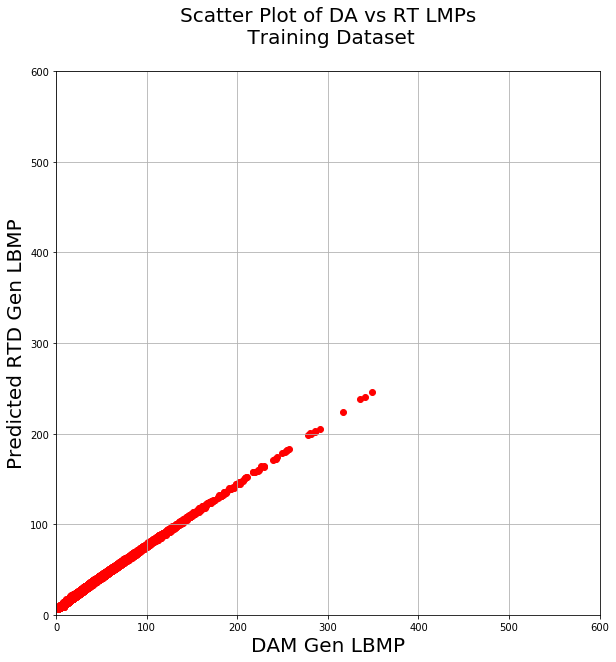

In [164]:
x = df_train[da_lmp_label]
y = preds3

fig = plt.figure(figsize=(10, 10))

# plt.hist(dfLMP['DA LMP'],label='Real' +'DA LMP'+ ' distribution',alpha=0.5,density=True,color='b')

# plt.hist(dfModel['RT Gen MW'],label='Monte RT Gen MW',alpha=0.5,density=True,color='r')
# plt.legend(loc='upper right')
plt.xlabel(da_lmp_label,fontsize = 20)
plt.ylabel('Predicted '+rt_lmp_label, fontsize = 20)

plt.xlim(0, 600)
plt.ylim(0, 600)
plt.gca().set_aspect('equal', adjustable='box')

plt.title('Scatter Plot of DA vs RT LMPs\n Training Dataset\n' ,fontdict = {'fontsize' : 20})
plt.grid(True)

plt.scatter(x,y,color='red')

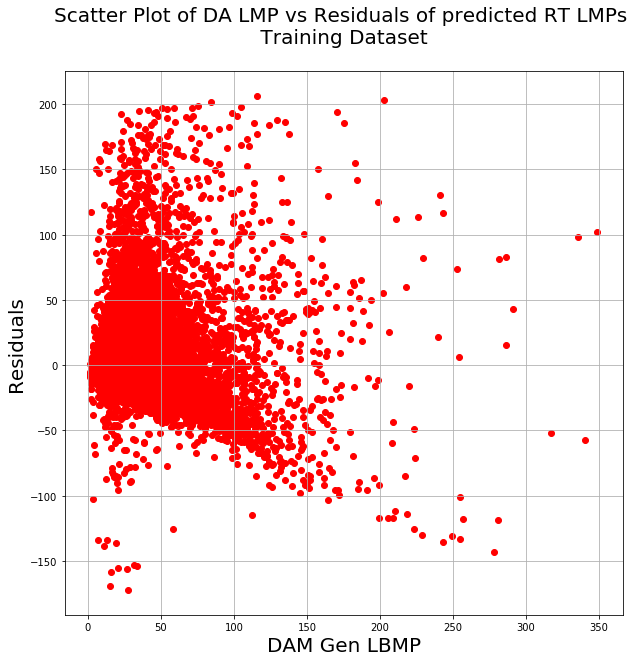

In [158]:
x = df_train[da_lmp_label]
y = residuals3

fig = plt.figure(figsize=(10, 10))

# plt.hist(dfLMP['DA LMP'],label='Real' +'DA LMP'+ ' distribution',alpha=0.5,density=True,color='b')

# plt.hist(dfModel['RT Gen MW'],label='Monte RT Gen MW',alpha=0.5,density=True,color='r')
# plt.legend(loc='upper right')
plt.xlabel(da_lmp_label,fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)

# plt.xlim(0, 100)
# plt.ylim(0, 200)
# plt.gca().set_aspect('equal', adjustable='box')

plt.title('Scatter Plot of DA LMP vs Residuals of predicted RT LMPs \n Training Dataset \n' ,fontdict = {'fontsize' : 20})
plt.grid(True)

plt.scatter(x,y,color='red')

In [125]:
df_train['Residuals'] = residuals3
df_train['Regression'] = preds3

{'whiskers': [<matplotlib.lines.Line2D at 0x24d243dc188>,
 'caps': [<matplotlib.lines.Line2D at 0x24d1e8f0648>,
 'boxes': [<matplotlib.lines.Line2D at 0x24d243dcec8>],
 'medians': [<matplotlib.lines.Line2D at 0x24d1c3acf48>],
 'fliers': [<matplotlib.lines.Line2D at 0x24d1c3ac408>],
 'means': []}

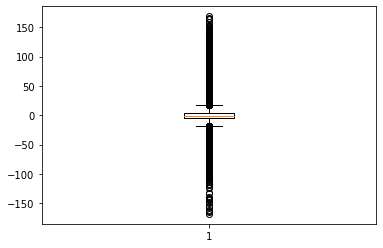

In [126]:
plt.boxplot(df_train['Residuals'])

In [127]:
df_train

,Hour Beginning,.Z.MAINE Day Ahead Price,.Z.MAINE Real Time Price,ME Forecast Load,ME Actual Load,Month,Summer,Winter,Shoulder,Difference,Outlier,Residuals,Regression
Transaction Dates (Calculated),,,,,,,,,,,,,
2016-01-01 00:00:00,0,39.83,32.67,986.3,1169.000,1,0,1,0,-7.16,0,-5.786247,38.456247
2016-01-01 01:00:00,1,35.30,34.42,933.9,1102.714,1,0,1,0,-0.88,0,0.359409,34.060591
2016-01-01 02:00:00,2,30.00,29.89,897.3,1056.040,1,0,1,0,-0.11,0,0.968507,28.921493
2016-01-01 03:00:00,3,29.49,17.98,907.2,1026.557,1,0,1,0,-11.51,0,-10.427186,28.407186
2016-01-01 04:00:00,4,29.56,8.64,913.3,1015.983,1,0,1,0,-20.92,0,-19.812875,28.452875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,19,30.24,27.66,1257.5,1558.337,12,0,1,0,-2.58,0,-1.120965,28.780965
2020-12-31 20:00:00,20,29.75,23.95,1206.0,1490.857,12,0,1,0,-5.80,0,-4.335969,28.285969
2020-12-31 21:00:00,21,29.97,39.27,1085.2,1427.265,12,0,1,0,9.30,0,10.793516,28.476484


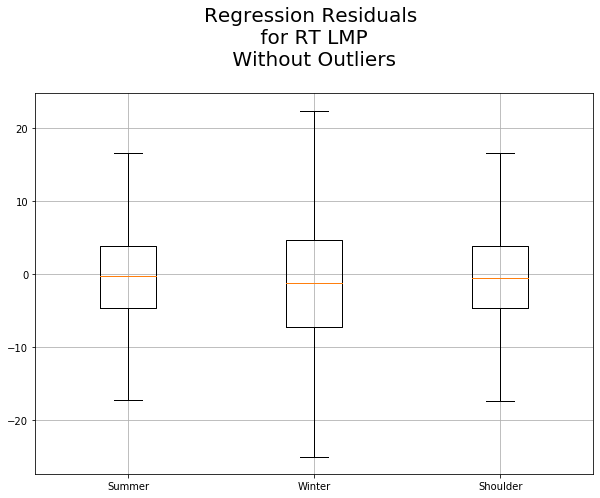

In [128]:
fig = plt.figure(figsize=(10, 7))

A = df_train['Residuals'][df_train.index.month.isin(summer)]
B = df_train['Residuals'][df_train.index.month.isin(winter)]
C = df_train['Residuals'][df_train.index.month.isin(shoulder)]

data = [A, B, C]
plt.boxplot(data,labels=['Summer','Winter','Shoulder'],showfliers=False)

# plt.xlabel(xname,fontsize = 20)
# plt.ylabel('Density', fontsize = 20)
plt.title("Regression Residuals \n for RT LMP \n Without Outliers \n " ,fontdict = {'fontsize' : 20})
plt.grid(True)

In [129]:
i = 0
s = 0

res_sum = [0 for i in range(24)]
res_win = [0 for i in range(24)]
res_sho = [0 for i in range(24)]


for hour in range(24):
        
    res_sum[i] = df_train['Residuals'][(df_train.index.month.isin(summer))&(df_train.index.hour == hour)].values 
    
    res_win[i] = df_train['Residuals'][(df_train.index.month.isin(winter))&(df_train.index.hour == hour)].values 
    
    res_sho[i] = df_train['Residuals'][(df_train.index.month.isin(shoulder))&(df_train.index.hour == hour)].values 
    
    i = i+1
    
res_sum = np.array(res_sum)
res_win = np.array(res_win)
res_sho = np.array(res_sho)


In [130]:
res_win.shape

(24, 452)

In [131]:
df_train.to_excel('Training Set with Residuals.xlsx')

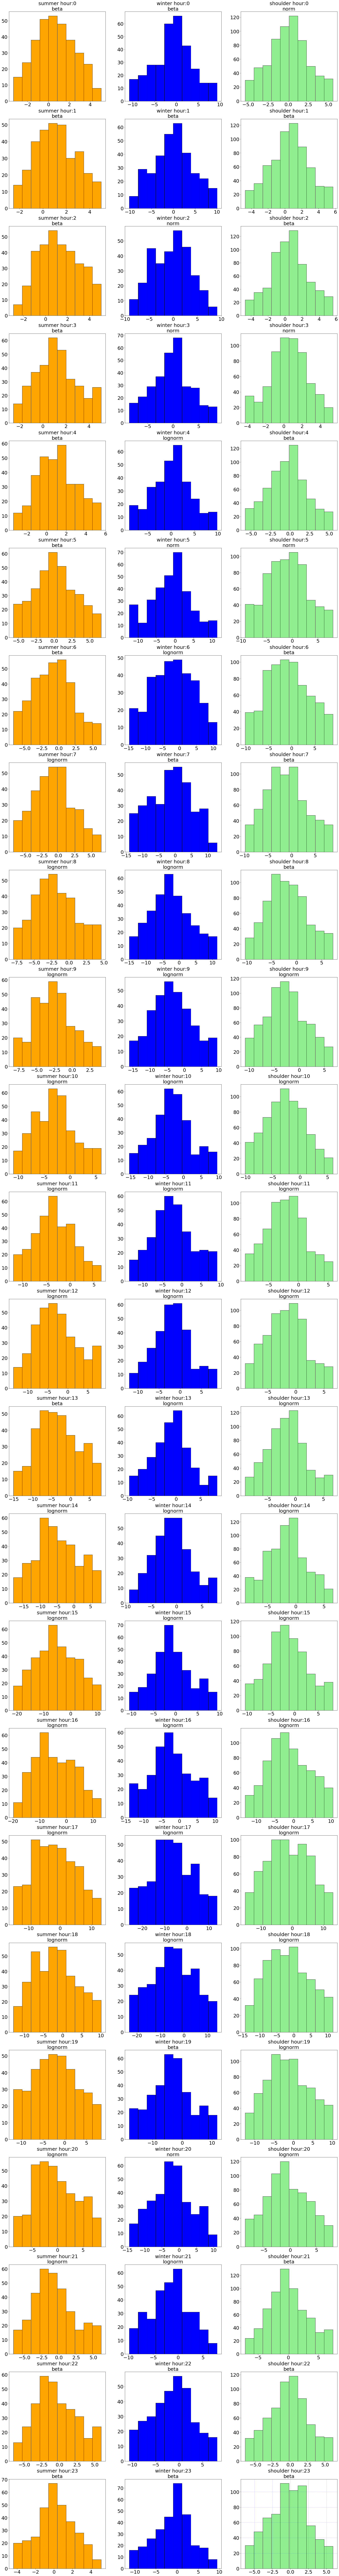

In [132]:
fig, axes = plt.subplots(24, 3,figsize=(30, 240))

# fig.suptitle('RT LMP Regression Residual Distributions')

char = ['summer','winter','shoulder']

colors = ['orange','blue','lightgreen']


# df = df_DA.copy()

m=0
for i in range(24):
    axes[i, 0].hist(reject_outliers(res_sum[i]), bins = 10, color = colors[0],edgecolor='black')
    
    axes[i, 1].hist(reject_outliers(res_win[i]), bins = 10, color = colors[1],edgecolor='black')
    
    axes[i, 2].hist(reject_outliers(res_sho[i]), bins = 10, color = colors[2],edgecolor='black')
    

    for j in range(3):
                
        axes[i][j].tick_params(axis='both', which='both', labelsize=25)
        
        title1 = char[j]+" hour:"+str(i)
        
        if j == 0:
            b,lol = Fitting(res_sum[i])
            
        if j == 1:
            b,lol = Fitting(res_win[i])
            
        if j == 2:
            b,lol = Fitting(res_sho[i])
            
        title2 = b
        axes[i][j].set_title(title1+'\n'+title2,fontdict={'fontsize':25})
        
        for tick in axes[i][j].get_xticklabels():
            tick.set_visible(True)
            
plt.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.savefig('Test1.png')

# Test

In [217]:
df_test

,Hour Beginning,.Z.MAINE Day Ahead Price,.Z.MAINE Real Time Price,ME Forecast Load,ME Actual Load,Month,Summer,Winter,Shoulder
Transaction Dates (Calculated),,,,,,,,,
2021-01-01 00:00:00,0,22.11,25.62,549.1,1246.73,1,0,1,0
2021-01-01 01:00:00,1,21.98,42.53,865.1,1197.54,1,0,1,0
2021-01-01 02:00:00,2,21.9,23.61,813.9,1159.91,1,0,1,0
2021-01-01 03:00:00,3,21.65,23.89,797.3,1139.11,1,0,1,0
2021-01-01 04:00:00,4,22.05,23.82,810.5,1138.64,1,0,1,0
...,...,...,...,...,...,...,...,...,...
2021-10-04 20:00:00,20,-,-,-,-,10,0,0,1
2021-10-04 21:00:00,21,-,-,-,-,10,0,0,1
2021-10-04 22:00:00,22,-,-,-,-,10,0,0,1


In [218]:
df_test = df_test[df_test[rt_lmp_label] != '-']

df_test[rt_lmp_label] = pd.to_numeric(df_test[rt_lmp_label])
df_test[da_lmp_label] = pd.to_numeric(df_test[da_lmp_label])


# df_test['Difference'] = df_test[rt_lmp_label] - df_test[da_lmp_label]

In [219]:
input_array = df_test[[da_lmp_label,'Hour Beginning']]
preds = model3.predict(input_array)

In [220]:
preds

Transaction Dates (Calculated)
2021-01-01 00:00:00    21.347417
2021-01-01 01:00:00    21.200004
2021-01-01 02:00:00    21.100866
2021-01-01 03:00:00    20.837591
2021-01-01 04:00:00    21.201898
                         ...    
2021-05-11 02:00:00    21.477414
2021-05-11 03:00:00    22.942402
2021-05-11 04:00:00    24.783939
2021-05-11 05:00:00    27.397883
2021-05-11 06:00:00    35.573162
Length: 3120, dtype: float64

In [221]:
df_test['Regression'] = preds
df_test['Residual'] = 0

In [222]:
df_test

,Hour Beginning,.Z.MAINE Day Ahead Price,.Z.MAINE Real Time Price,ME Forecast Load,ME Actual Load,Month,Summer,Winter,Shoulder,Regression,Residual
Transaction Dates (Calculated),,,,,,,,,,,
2021-01-01 00:00:00,0,22.11,25.62,549.1,1246.73,1,0,1,0,21.347417,0
2021-01-01 01:00:00,1,21.98,42.53,865.1,1197.54,1,0,1,0,21.200004,0
2021-01-01 02:00:00,2,21.90,23.61,813.9,1159.91,1,0,1,0,21.100866,0
2021-01-01 03:00:00,3,21.65,23.89,797.3,1139.11,1,0,1,0,20.837591,0
2021-01-01 04:00:00,4,22.05,23.82,810.5,1138.64,1,0,1,0,21.201898,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 02:00:00,2,22.29,22.57,-,-,5,0,0,1,21.477414,0
2021-05-11 03:00:00,3,23.83,23.81,-,-,5,0,0,1,22.942402,0
2021-05-11 04:00:00,4,25.76,30.50,-,-,5,0,0,1,24.783939,0


In [223]:
#Residual Monte Carlo Loop

In [224]:
df_test['Season'] = ''

In [225]:
df_test['Season'][df_test['Winter']==1] = 'Winter'
df_test['Season'][df_test['Shoulder']==1] = 'Shoulder'
df_test['Season'][df_test['Summer']==1] = 'Summer'

In [226]:
df_test[df_test['Winter']==1]

,Hour Beginning,.Z.MAINE Day Ahead Price,.Z.MAINE Real Time Price,ME Forecast Load,ME Actual Load,Month,Summer,Winter,Shoulder,Regression,Residual,Season
Transaction Dates (Calculated),,,,,,,,,,,,
2021-01-01 00:00:00,0,22.11,25.62,549.1,1246.73,1,0,1,0,21.347417,0,Winter
2021-01-01 01:00:00,1,21.98,42.53,865.1,1197.54,1,0,1,0,21.200004,0,Winter
2021-01-01 02:00:00,2,21.90,23.61,813.9,1159.91,1,0,1,0,21.100866,0,Winter
2021-01-01 03:00:00,3,21.65,23.89,797.3,1139.11,1,0,1,0,20.837591,0,Winter
2021-01-01 04:00:00,4,22.05,23.82,810.5,1138.64,1,0,1,0,21.201898,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 19:00:00,19,43.22,44.56,1349,1495.67,2,0,1,0,41.313280,0,Winter
2021-02-28 20:00:00,20,35.14,44.01,1244.9,1432.79,2,0,1,0,33.490065,0,Winter
2021-02-28 21:00:00,21,32.70,32.71,1149.4,1357.61,2,0,1,0,31.112325,0,Winter


In [227]:
res_sum

array([[10.74491086,  2.03874258,  3.2366776 , ..., -1.63951068,
        -2.30436378,  2.32905638],
       [ 6.50266908,  1.60166769,  1.01098677, ..., -1.1352104 ,
        -3.10384633, -0.36008793],
       [ 6.33318431,  3.3311371 ,  2.07012016, ..., -1.14366712,
        -0.10369822, -0.86336665],
       ...,
       [ 8.03272872,  2.29272872,  2.5561711 , ..., 10.72655822,
        -5.31695081, -0.53900469],
       [ 4.96564495,  2.57324395,  7.90217813, ..., 11.16084295,
        -8.99299321,  3.47530449],
       [ 3.64411075,  1.79067504,  0.73375474, ..., -0.15451408,
        -1.57144771,  4.66168309]])

In [228]:
df_test['Season']

Transaction Dates (Calculated)
2021-01-01 00:00:00      Winter
2021-01-01 01:00:00      Winter
2021-01-01 02:00:00      Winter
2021-01-01 03:00:00      Winter
2021-01-01 04:00:00      Winter
                         ...   
2021-05-11 02:00:00    Shoulder
2021-05-11 03:00:00    Shoulder
2021-05-11 04:00:00    Shoulder
2021-05-11 05:00:00    Shoulder
2021-05-11 06:00:00    Shoulder
Name: Season, Length: 3120, dtype: object

Summer Hour:  0
Number of data items =  0
Winter Hour:  0
Number of data items =  59
Shoulder Hour:  0
Number of data items =  71
Summer Hour:  1
Number of data items =  0
Winter Hour:  1
Number of data items =  59
Shoulder Hour:  1
Number of data items =  71
Summer Hour:  2
Number of data items =  0
Winter Hour:  2
Number of data items =  59
Shoulder Hour:  2
Number of data items =  72
Summer Hour:  3
Number of data items =  0
Winter Hour:  3
Number of data items =  59
Shoulder Hour:  3
Number of data items =  72
Summer Hour:  4
Number of data items =  0
Winter Hour:  4
Number of data items =  59
Shoulder Hour:  4
Number of data items =  72
Summer Hour:  5
Number of data items =  0
Winter Hour:  5
Number of data items =  59
Shoulder Hour:  5
Number of data items =  72
Summer Hour:  6
Number of data items =  0
Winter Hour:  6
Number of data items =  59
Shoulder Hour:  6
Number of data items =  72
Summer Hour:  7
Number of data items =  0
Winter Hour:  7
Number of data items =  59
Shoul

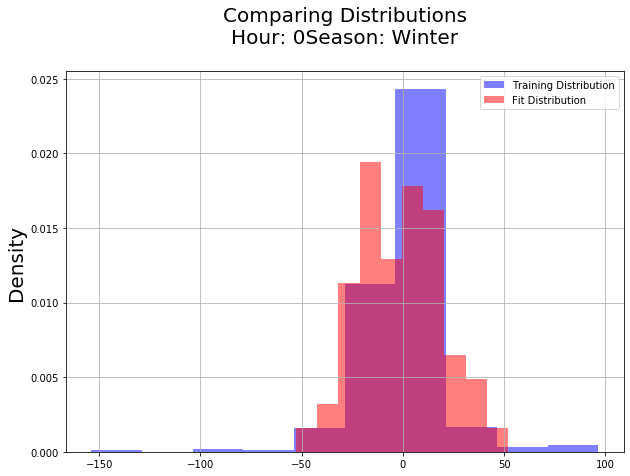

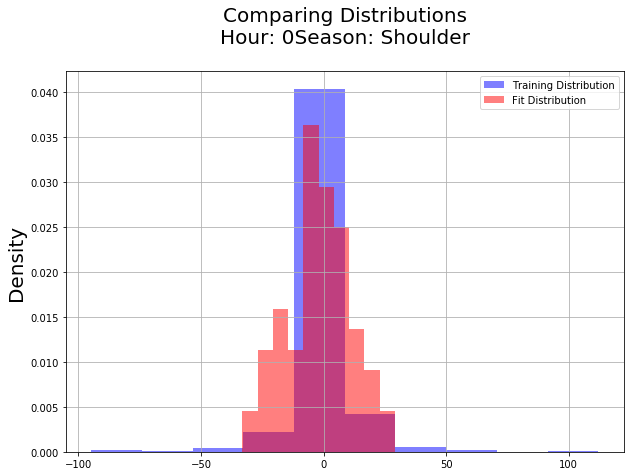

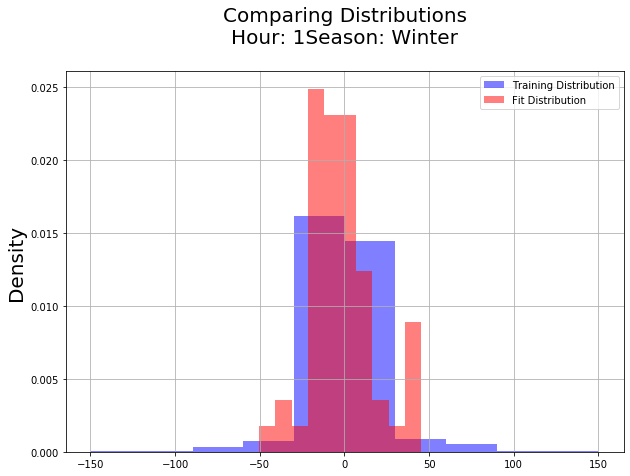

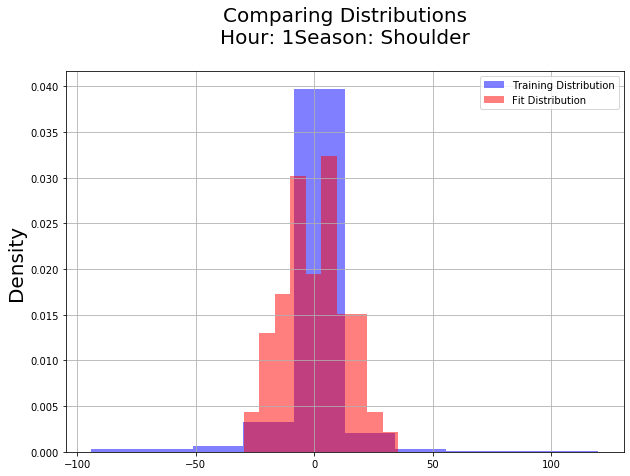

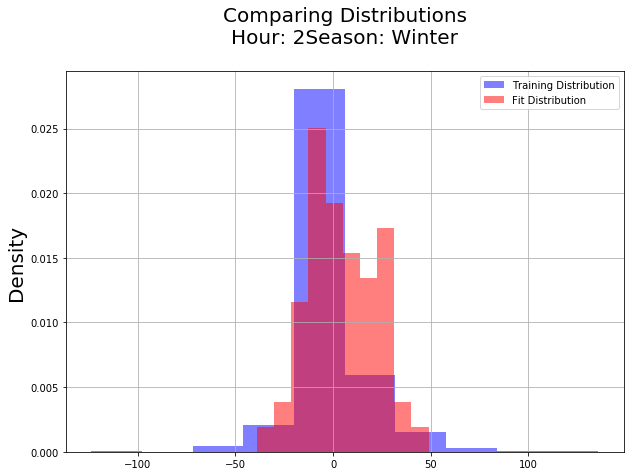

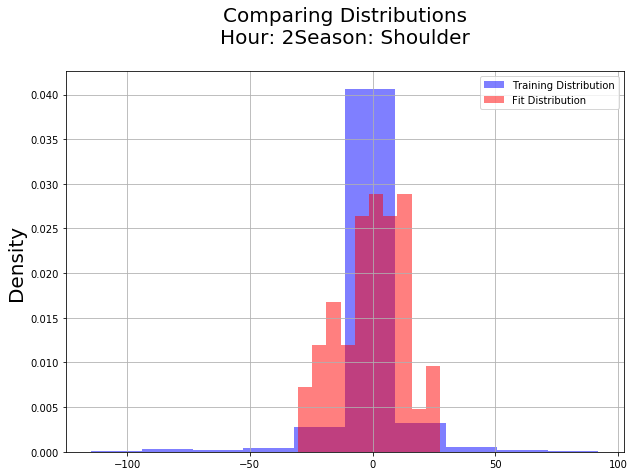

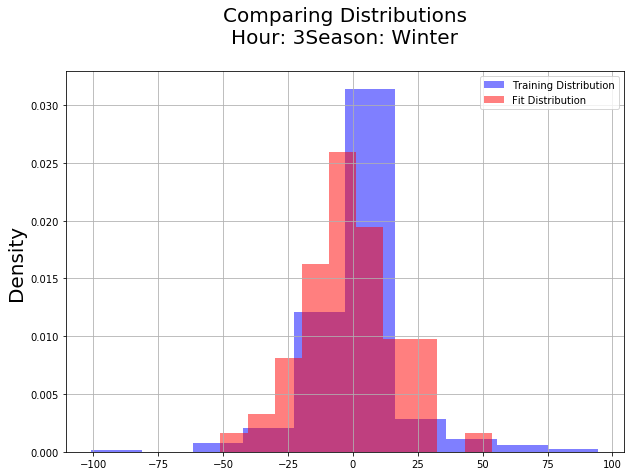

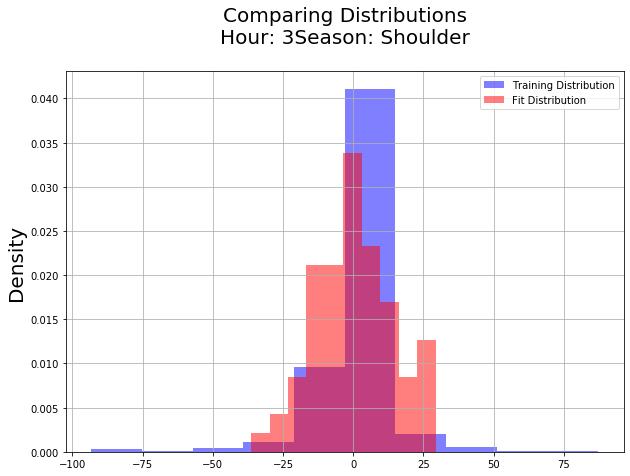

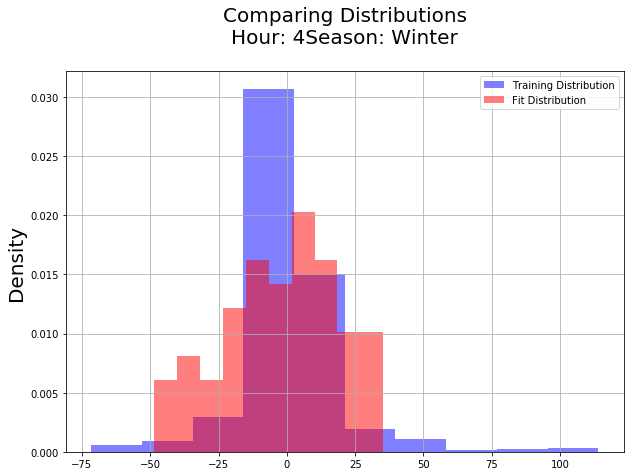

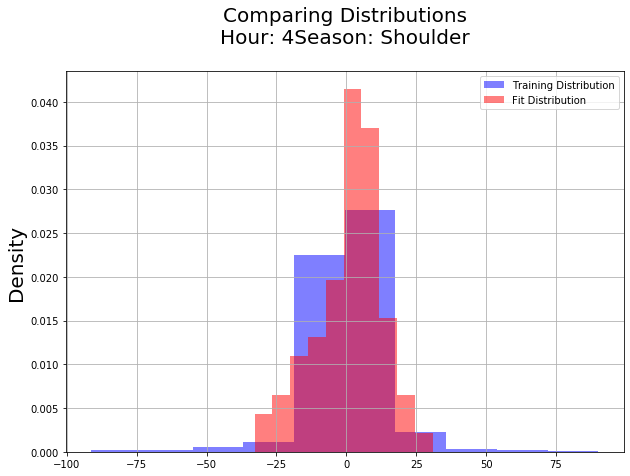

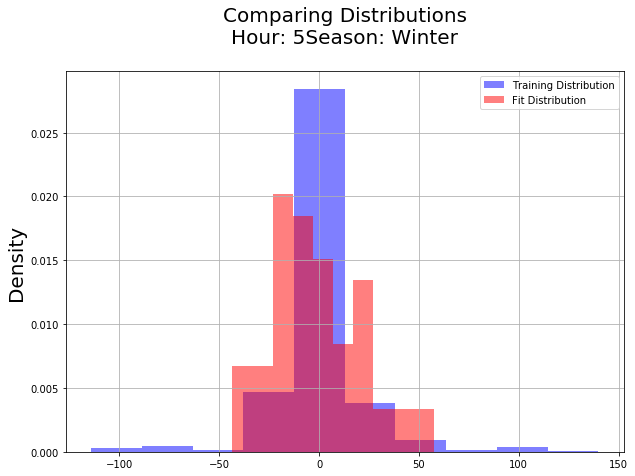

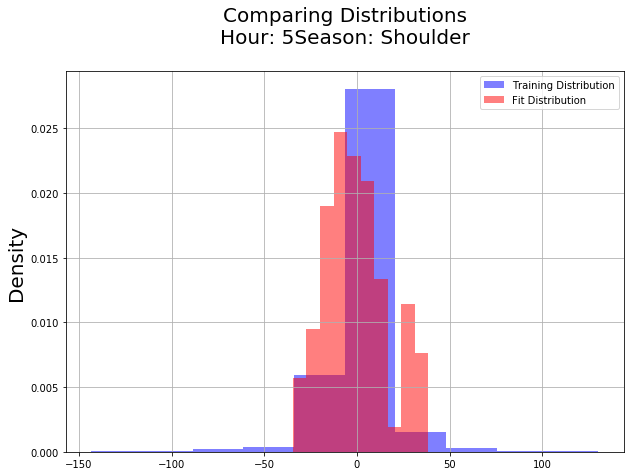

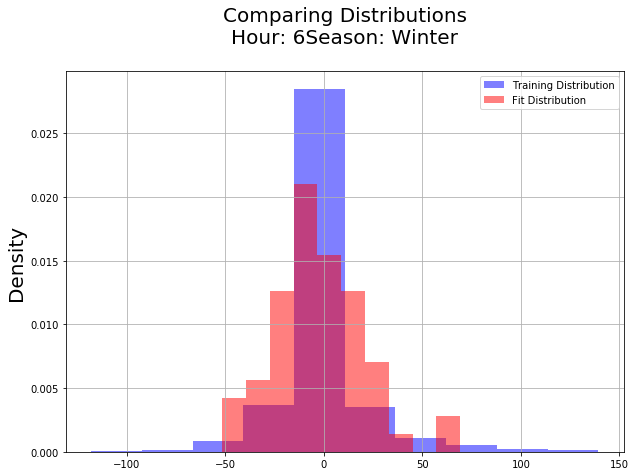

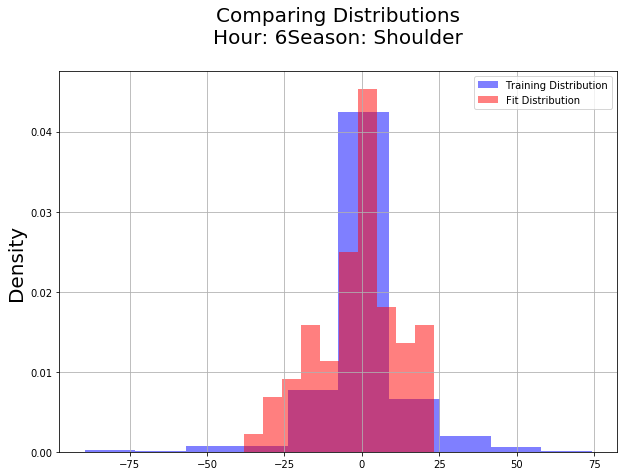

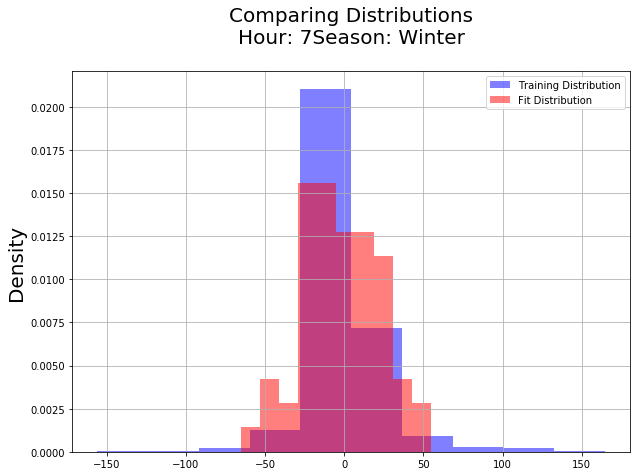

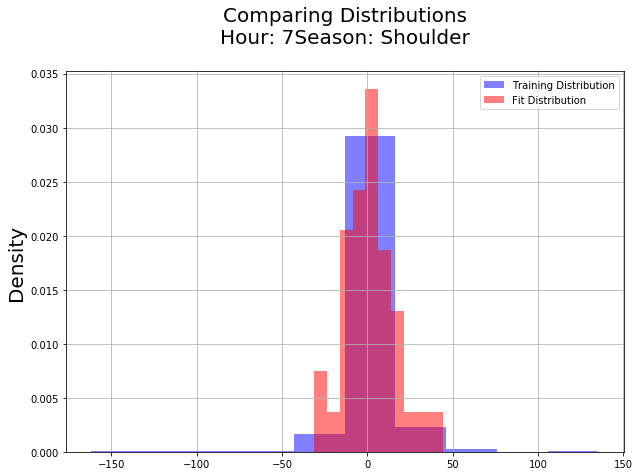

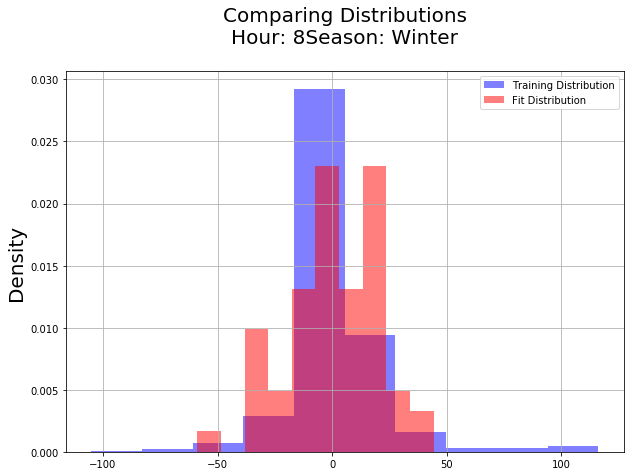

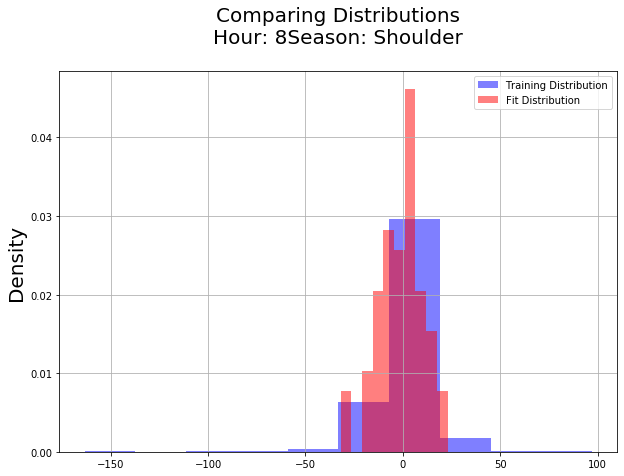

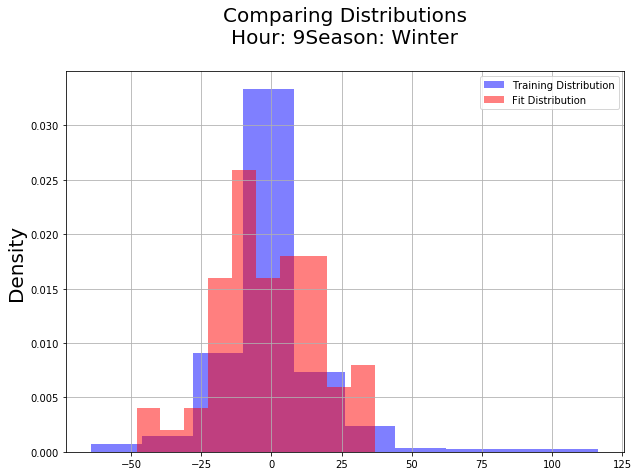

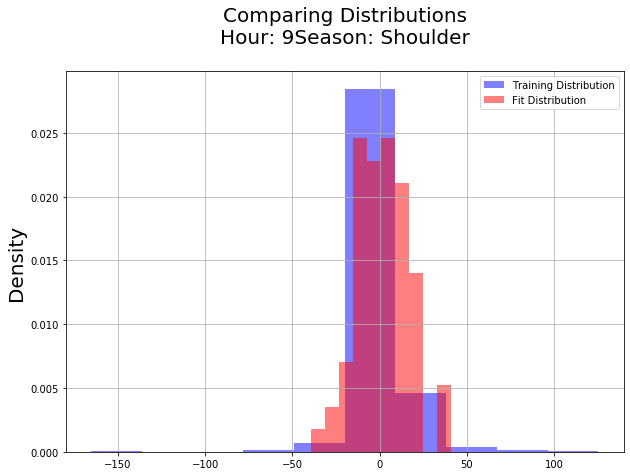

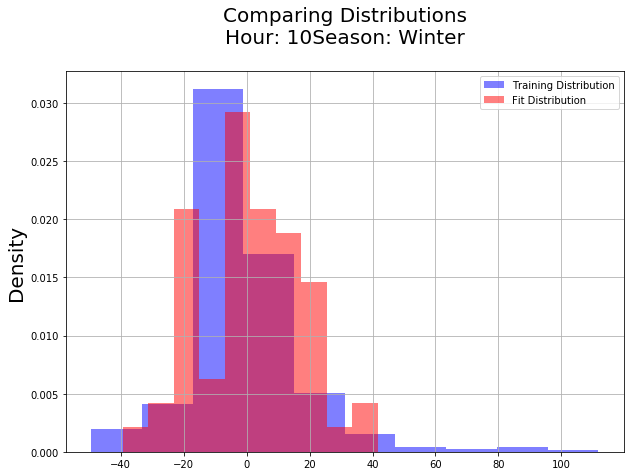

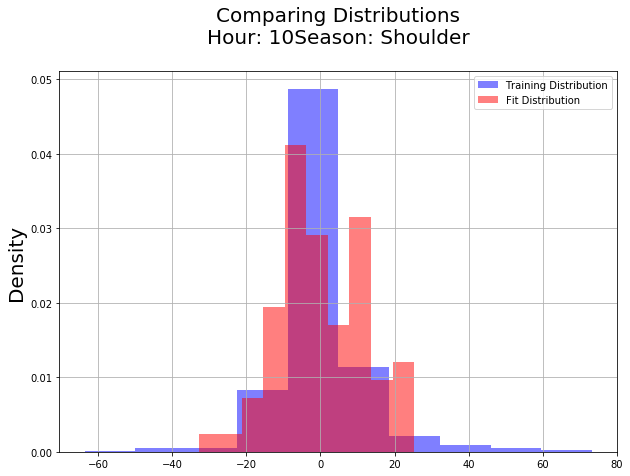

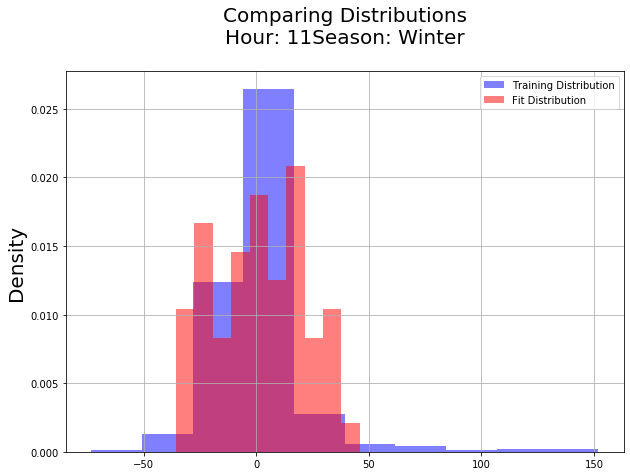

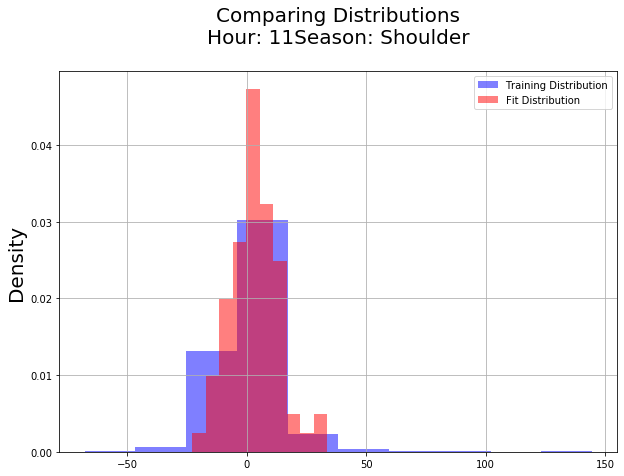

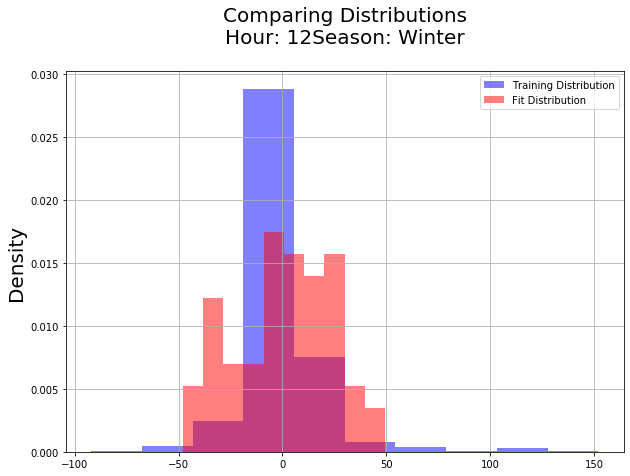

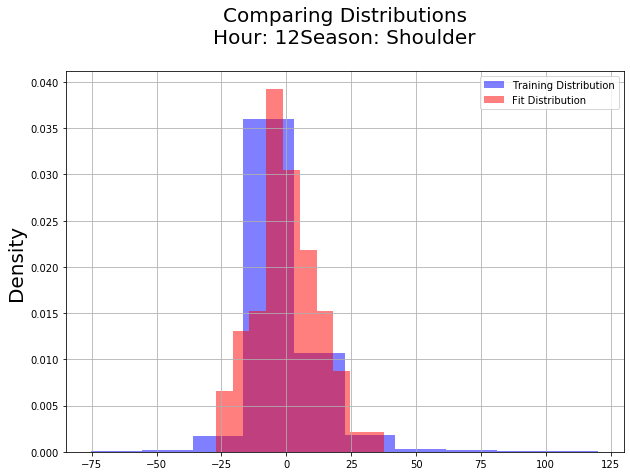

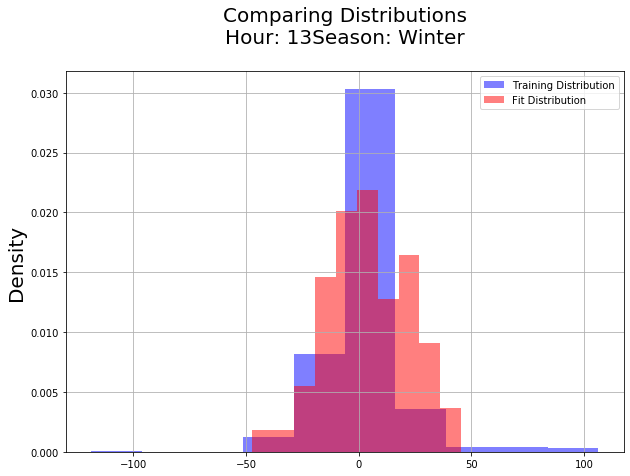

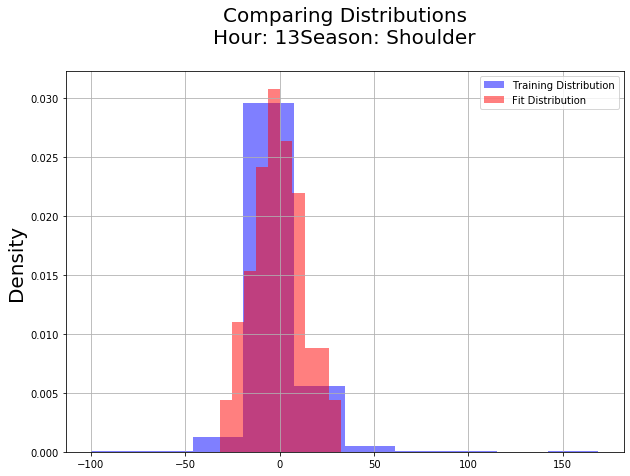

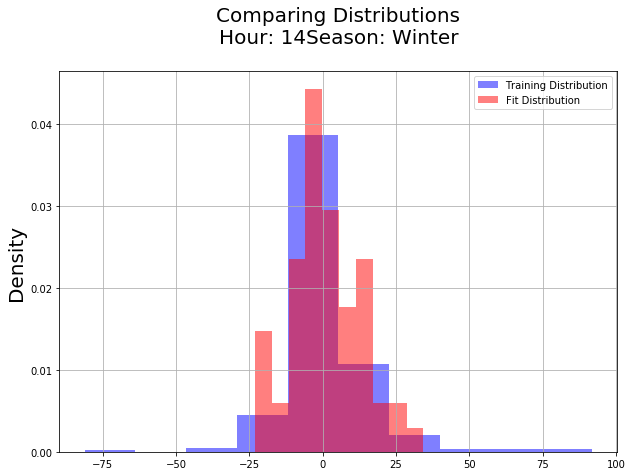

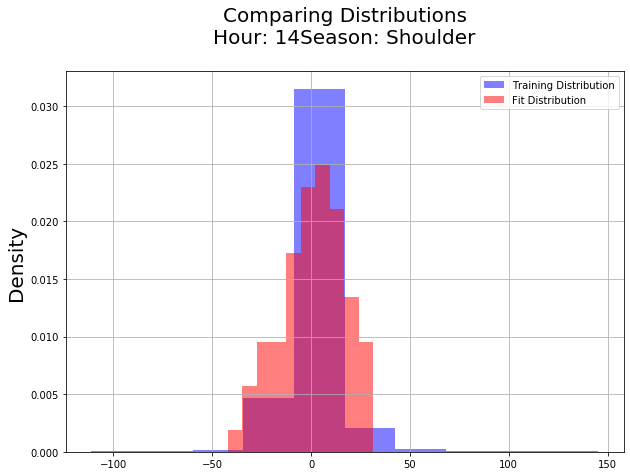

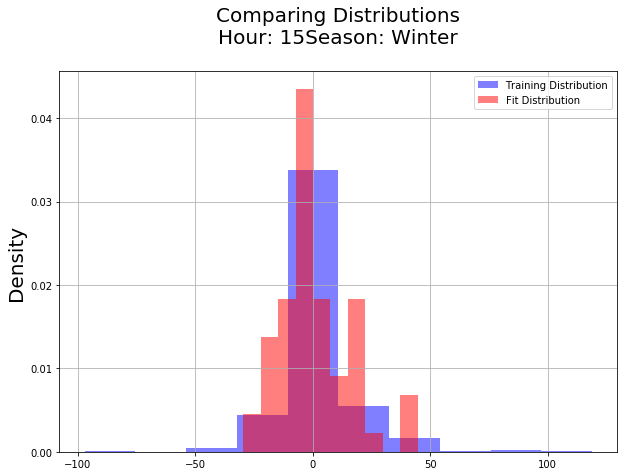

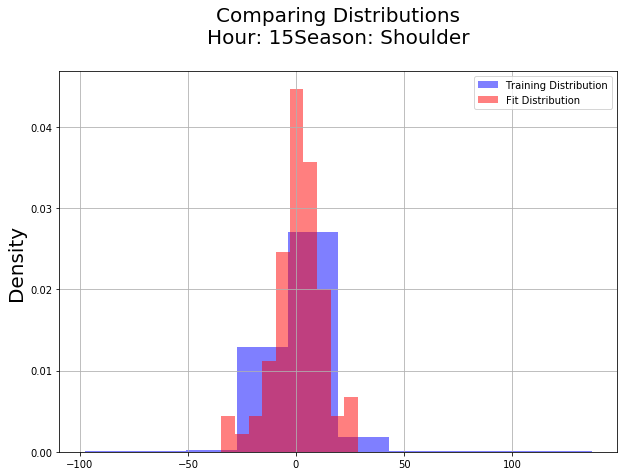

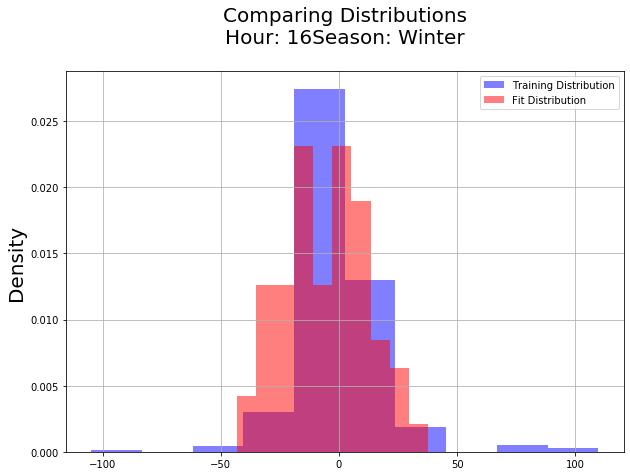

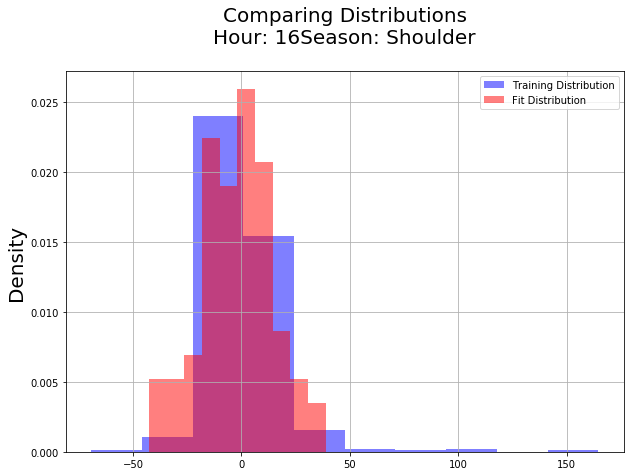

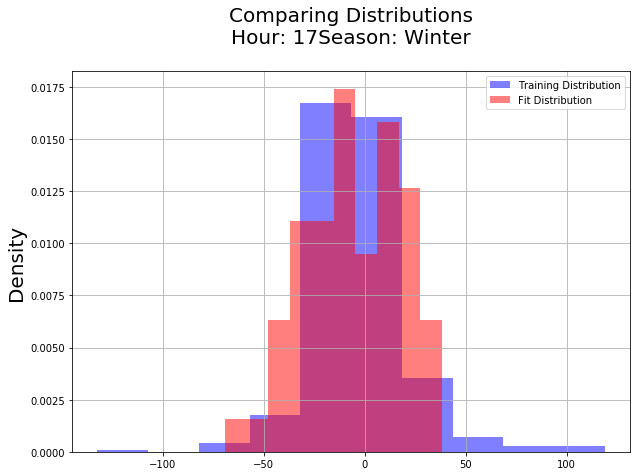

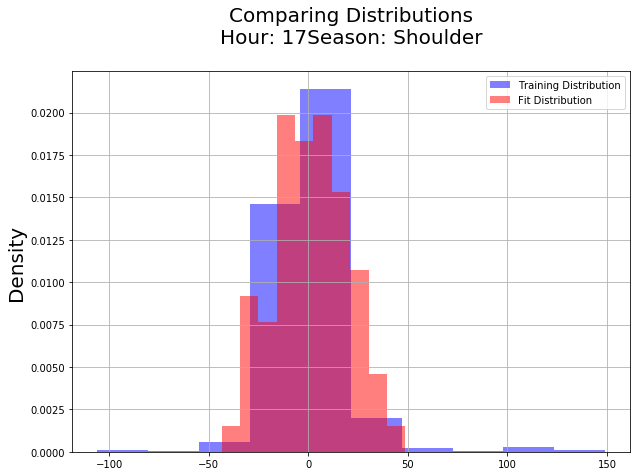

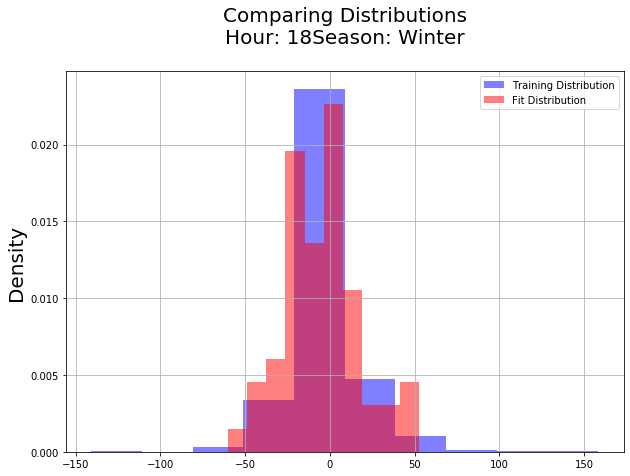

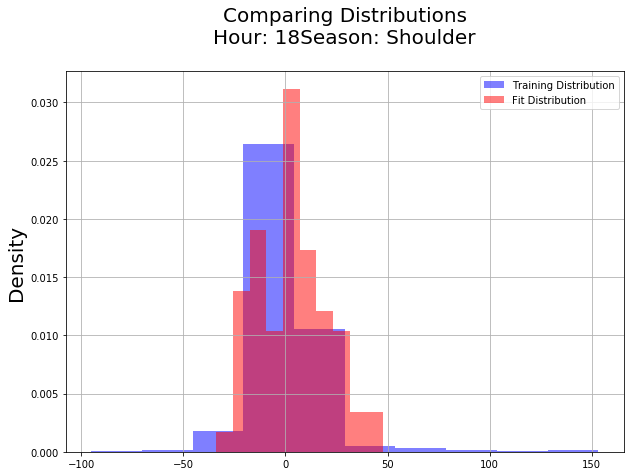

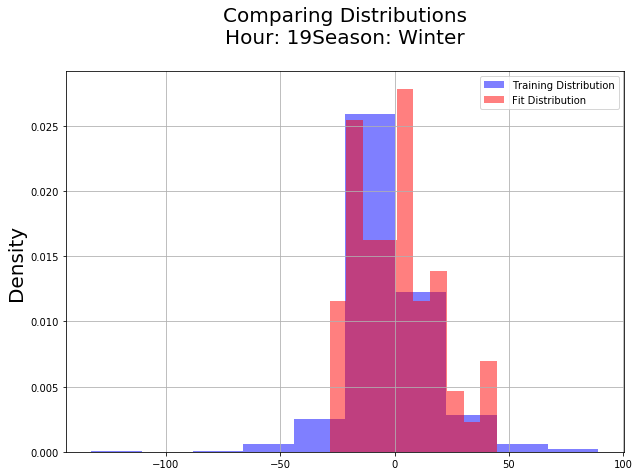

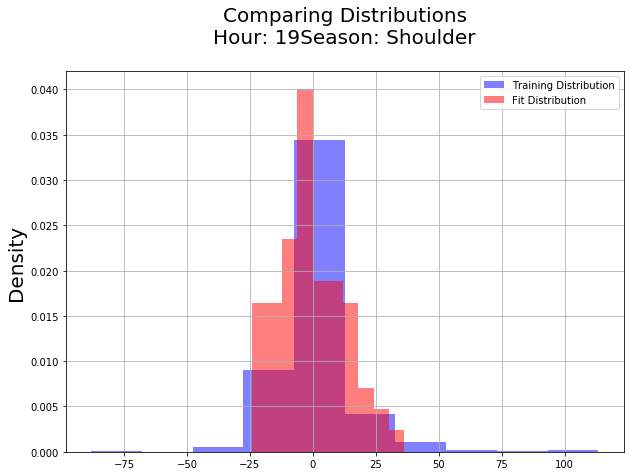

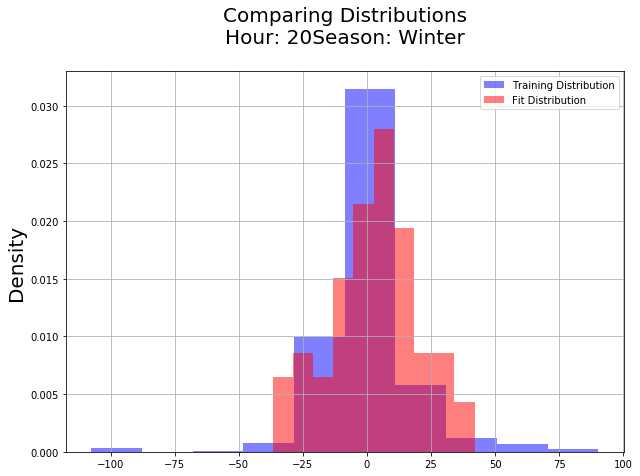

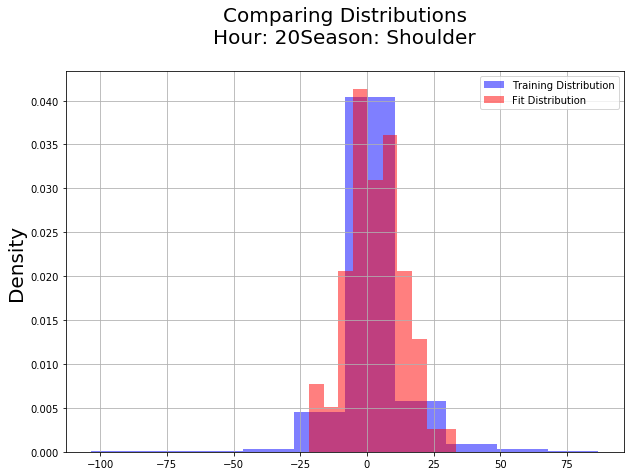

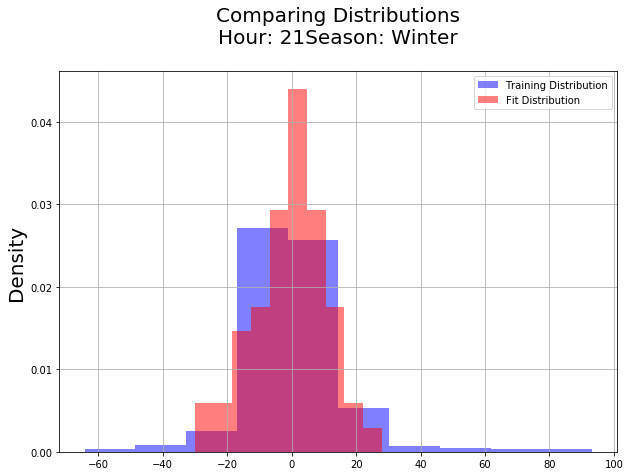

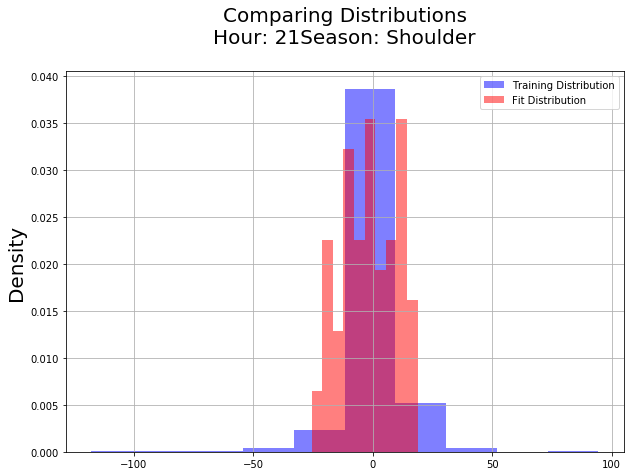

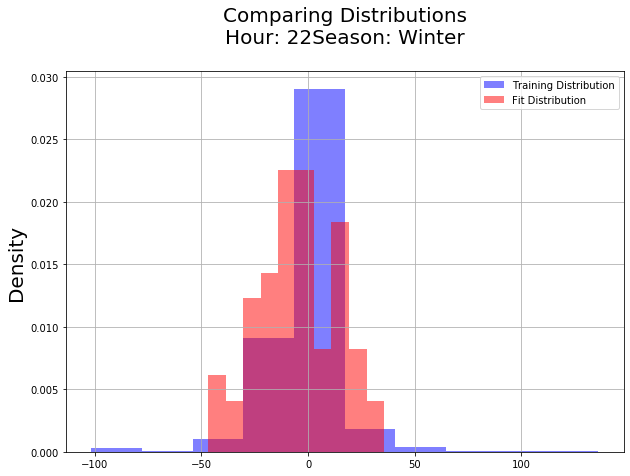

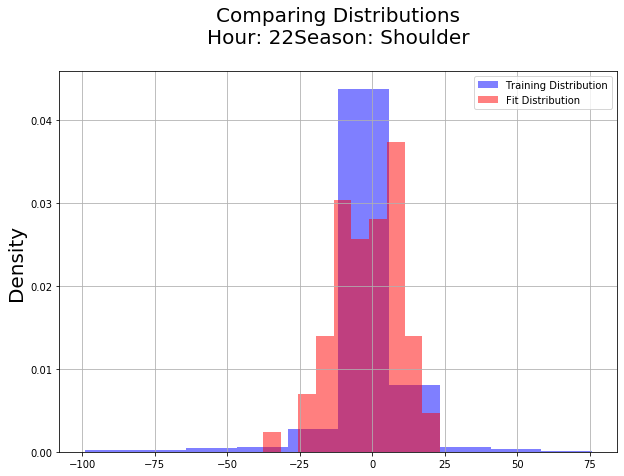

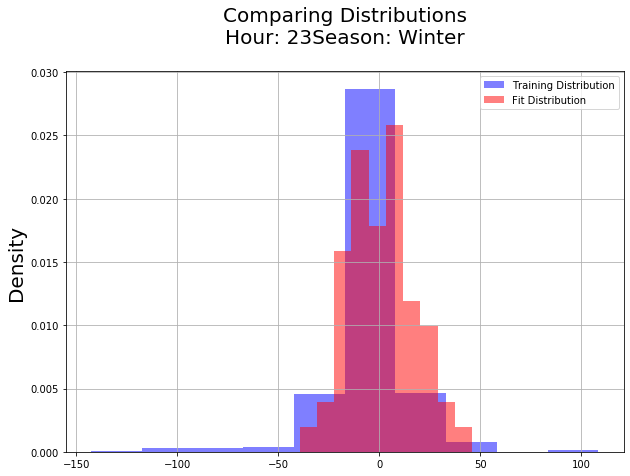

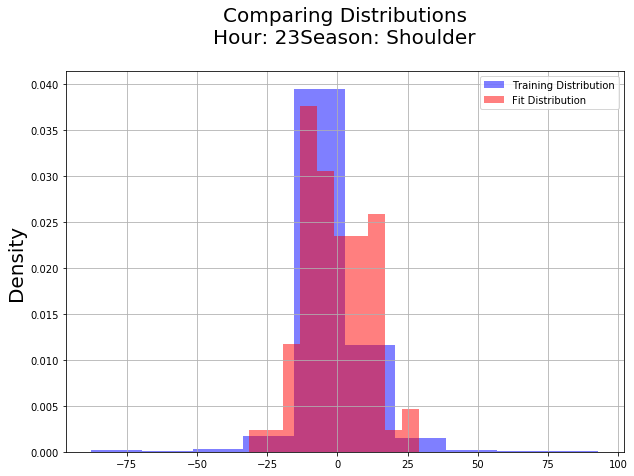

In [229]:
for i in range(24):
    
    print("Summer Hour: ",i)
    y = res_sum[i]
    
    try:
        fit_type,y_std = Fitting(y)
        length = len(df_test['Residual'][(df_test['Season'] =='Summer')&(df_test['Hour Beginning'] ==i)])
        print("Number of data items = ",length)
        df_test['Residual'][(df_test['Season'] =='Summer')&(df_test['Hour Beginning'] ==i)] = random_func(fit_type,y,y_std)[0:length]
    
    except:
        print('Previous fit type:'+str(fit_type)+' Corrected to norm')
        fit_type,y_std = Fitting(y)
        length = len(df_test['Residual'][(df_test['Season'] =='Summer')&(df_test['Hour Beginning'] ==i)])
        print("Number of data items = ",length)
        df_test['Residual'][(df_test['Season'] =='Summer')&(df_test['Hour Beginning'] ==i)] = random_func('norm',y,y_std)[0:length]
    
    try:
        print("Winter Hour: ",i)
        y = res_win[i]
        fit_type,y_std = Fitting(y)
        
        length = len(df_test[(df_test['Season'] =='Winter')&(df_test['Hour Beginning'] ==i)])
        print("Number of data items = ",length)
        rand = random_func(fit_type,y,y_std)[0:length]
        df_test['Residual'][(df_test['Season'] =='Winter')&(df_test['Hour Beginning'] ==i)] = rand
        
        visual_check_fit(y,rand,i,"Winter")
        
    except:
        print("Winter Hour: ",i)
        print('Previous fit type:'+str(fit_type)+' Corrected to norm')
        y = res_win[i]
        fit_type,y_std = Fitting(y)
        length = len(df_test[(df_test['Season'] =='Winter')&(df_test['Hour Beginning'] ==i)])
        print("Number of data items = ",length)
        
        rand = random_func('norm',y,y_std)[0:length]
        df_test['Residual'][(df_test['Season'] =='Winter')&(df_test['Hour Beginning'] ==i)] = rand
        
        visual_check_fit(y,rand,i,"Winter")
        
    try:
        print("Shoulder Hour: ",i)
        y = res_sho[i]
        fit_type,y_std = Fitting(y)
            
        length = len(df_test['Residual'][(df_test['Season'] =='Shoulder')&(df_test['Hour Beginning'] ==i)])
        print("Number of data items = ",length)
        rand = random_func(fit_type,y,y_std)[0:length]
        df_test['Residual'][(df_test['Season'] =='Shoulder')&(df_test['Hour Beginning'] ==i)] = rand
        visual_check_fit(y,rand,i,"Shoulder")
        
    except:
        print("Shoulder Hour: ",i)
        print('Previous fit type:'+str(fit_type)+' Corrected to norm')
        y = res_sho[i]
        fit_type,y_std = Fitting(y)
        length = len(df_test['Residual'][(df_test['Season'] =='Shoulder')&(df_test['Hour Beginning'] ==i)])
        print("Number of data items = ",length)
        df_test['Residual'][(df_test['Season'] =='Shoulder')&(df_test['Hour Beginning'] ==i)] = random_func('norm',y,y_std)[0:length]
    

In [230]:
df_test['Regression'] = pd.to_numeric(df_test['Regression']) 

df_test['Predicted RT LMP'] = df_test['Regression'] + df_test['Residual']

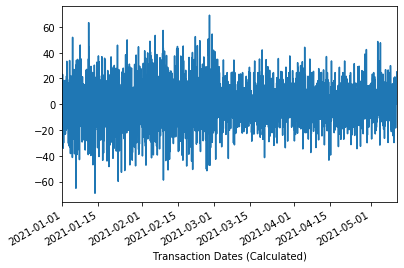

In [231]:
df_test['Residual'].plot()

In [232]:
a = df_test['Predicted RT LMP'].values
b = df_test[da_lmp_label].values


ro = np.corrcoef(a,b)

ro = ro[0][1]

y = b
y_std = (y-min(y))/(max(y)-min(y))

yMT = a
y_std_M = (yMT-min(yMT))/(max(yMT)-min(yMT))

#Cholesky Transform 
#https://en.wikipedia.org/wiki/Cholesky_decomposition
#Check under Applications->Monte Carlo smulation in above link
y_std_corr = ro*y_std_M + ((1 - ro**2)**0.5)*y_std

y_std_corr = (y_std_corr-min(y_std_corr))/(max(y_std_corr)-min(y_std_corr))
    
correlated_values = y_std_corr*(max(y)-min(y))+min(y)

df_test['Predicted RT LMP'] = correlated_values

In [233]:
df_test

,Hour Beginning,.Z.MAINE Day Ahead Price,.Z.MAINE Real Time Price,ME Forecast Load,ME Actual Load,Month,Summer,Winter,Shoulder,Regression,Residual,Season,Predicted RT LMP
Transaction Dates (Calculated),,,,,,,,,,,,,
2021-01-01 00:00:00,0,22.11,25.62,549.1,1246.73,1,0,1,0,21.347417,-14.555985,Winter,25.793415
2021-01-01 01:00:00,1,21.98,42.53,865.1,1197.54,1,0,1,0,21.200004,8.553275,Winter,35.589585
2021-01-01 02:00:00,2,21.90,23.61,813.9,1159.91,1,0,1,0,21.100866,23.201534,Winter,41.797655
2021-01-01 03:00:00,3,21.65,23.89,797.3,1139.11,1,0,1,0,20.837591,2.570616,Winter,32.727467
2021-01-01 04:00:00,4,22.05,23.82,810.5,1138.64,1,0,1,0,21.201898,17.314288,Winter,39.378797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-11 02:00:00,2,22.29,22.57,-,-,5,0,0,1,21.477414,8.452555,Shoulder,35.796813
2021-05-11 03:00:00,3,23.83,23.81,-,-,5,0,0,1,22.942402,25.185283,Shoulder,44.257027
2021-05-11 04:00:00,4,25.76,30.50,-,-,5,0,0,1,24.783939,0.221469,Shoulder,35.155130


In [234]:
df_test[df_test['Residual'].isnull()]

,Hour Beginning,.Z.MAINE Day Ahead Price,.Z.MAINE Real Time Price,ME Forecast Load,ME Actual Load,Month,Summer,Winter,Shoulder,Regression,Residual,Season,Predicted RT LMP
Transaction Dates (Calculated),,,,,,,,,,,,,


In [235]:
#Calculating RMSEs
rmse = (reject_outliers(df_test['Predicted RT LMP'].values - df_test[rt_lmp_label].values) ** 2).mean() ** .5
print(rmse)

rmse_win = ((df_test['Predicted RT LMP'][df_test.index.month.isin(winter)].values - df_test[rt_lmp_label][df_test.index.month.isin(winter)].values) ** 2).mean() ** .5
print(rmse_win)

rmse_sho = ((df_test['Predicted RT LMP'][df_test.index.month.isin(shoulder)].values - df_test[rt_lmp_label][df_test.index.month.isin(shoulder)].values) ** 2).mean() ** .5
print(rmse_sho)

rmse_reg_only = ((df_test['Regression'].values - df_test[rt_lmp_label].values) ** 2).mean() ** .5
print(rmse_reg_only)

12.768212115187142
21.570086022451214
15.724093861858261
14.907788828191123


In [236]:
#Calculating MAEs

mae = ((df_test['Predicted RT LMP'].values - df_test[rt_lmp_label].values) ** 1).mean() 
print(mae)

mae_win = ((df_test['Predicted RT LMP'][df_test.index.month.isin(winter)].values - df_test[rt_lmp_label][df_test.index.month.isin(winter)].values) ** 1).mean() 
print(mae_win)

mae_sho = ((df_test['Predicted RT LMP'][df_test.index.month.isin(shoulder)].values - df_test[rt_lmp_label][df_test.index.month.isin(shoulder)].values) ** 1).mean() 
print(mae_sho)

mae_reg_only = ((df_test['Regression'].values - df_test[rt_lmp_label].values) ** 1).mean()
print(mae_reg_only)

7.541628347396939
4.491046368026452
10.076619006310443
-0.8845027069158579


In [237]:
#MAE is very low but RMSE is high. This could mean two things:
#1. Peaks and Troughs aren't coincident (we are probably missing a regression variable or a correlation)
#2. There is a consistent bias in one/more seasons
#3. RMSE's sensitivity to outliers is the primary issue which can't be solved for 

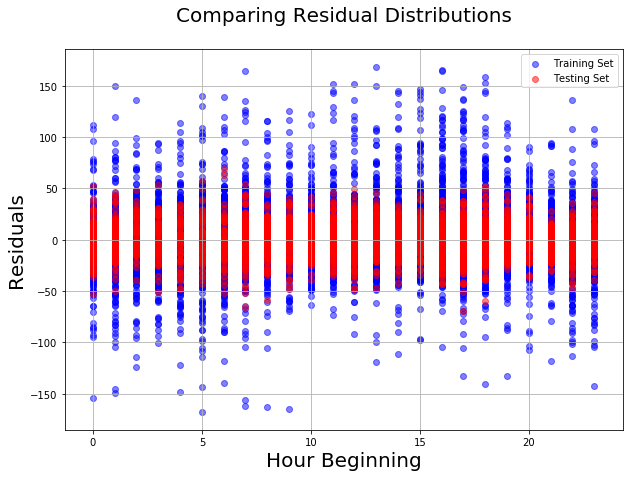

In [238]:
fig = plt.figure(figsize=(10, 7))

plt.scatter(df_train['Hour Beginning'],df_train['Residuals'],alpha=0.5,color='b',label='Training Set')
plt.scatter(df_test['Hour Beginning'],df_test['Residual'],alpha=0.5,color='r',label='Testing Set')


plt.legend(loc='upper right')
plt.xlabel('Hour Beginning',fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)

plt.title('Comparing Residual Distributions\n' ,fontdict = {'fontsize' : 20})
plt.grid(True)
#     fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

In [239]:
df_test['Error'] = (df_test[rt_lmp_label] - df_test['Predicted RT LMP'])

{'whiskers': [<matplotlib.lines.Line2D at 0x24d2ccd8fc8>,
 'caps': [<matplotlib.lines.Line2D at 0x24d2ccdffc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x24d2ccd8e48>],
 'medians': [<matplotlib.lines.Line2D at 0x24d2cce2f48>],
 'fliers': [<matplotlib.lines.Line2D at 0x24d2cce8dc8>],
 'means': []}

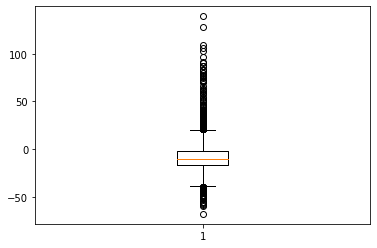

In [240]:
plt.boxplot(df_test['Error'])

In [241]:
df_test.to_excel('Test Dataset RT LMP.xlsx')

In [ ]:
df_test['Predicted ']

# Predict

In [314]:
idx = pd.date_range('1/1/2021', periods=8760, freq='H')

df_predict = pd.DataFrame(idx)

In [315]:
df_predict.index = idx

In [316]:
df_predict['Month'] = df_predict.index.month
df_predict['Hour'] = df_predict.index.hour


df_predict['Season'] = 0
df_predict['Season'][df_predict.index.month.isin(summer)] = "Summer"
df_predict['Season'][df_predict.index.month.isin(winter)] = "Winter"
df_predict['Season'][df_predict.index.month.isin(shoulder)] = "Shoulder"

In [317]:
df_predict[da_lmp_label] = df_test[da_lmp_label]

In [318]:
df_predict[da_lmp_label][df_predict[da_lmp_label].isna() == True] = df_train[da_lmp_label][df_train.index.year==2019].values

In [319]:
df_predict

,0,Month,Hour,Season,.Z.MAINE Day Ahead Price
2021-01-01 00:00:00,2021-01-01 00:00:00,1,0,Winter,22.11
2021-01-01 01:00:00,2021-01-01 01:00:00,1,1,Winter,21.98
2021-01-01 02:00:00,2021-01-01 02:00:00,1,2,Winter,21.90
2021-01-01 03:00:00,2021-01-01 03:00:00,1,3,Winter,21.65
2021-01-01 04:00:00,2021-01-01 04:00:00,1,4,Winter,22.05
...,...,...,...,...,...
2021-12-31 19:00:00,2021-12-31 19:00:00,12,19,Winter,23.41
2021-12-31 20:00:00,2021-12-31 20:00:00,12,20,Winter,23.58
2021-12-31 21:00:00,2021-12-31 21:00:00,12,21,Winter,21.89
2021-12-31 22:00:00,2021-12-31 22:00:00,12,22,Winter,21.58


In [320]:
input_array = df_predict[[da_lmp_label,"Hour"]].to_numpy()
preds = model3.predict(input_array)

df_predict['Regression'] = preds 

In [321]:
df_predict

,0,Month,Hour,Season,.Z.MAINE Day Ahead Price,Regression
2021-01-01 00:00:00,2021-01-01 00:00:00,1,0,Winter,22.11,21.347417
2021-01-01 01:00:00,2021-01-01 01:00:00,1,1,Winter,21.98,21.200004
2021-01-01 02:00:00,2021-01-01 02:00:00,1,2,Winter,21.90,21.100866
2021-01-01 03:00:00,2021-01-01 03:00:00,1,3,Winter,21.65,20.837591
2021-01-01 04:00:00,2021-01-01 04:00:00,1,4,Winter,22.05,21.201898
...,...,...,...,...,...,...
2021-12-31 19:00:00,2021-12-31 19:00:00,12,19,Winter,23.41,22.186535
2021-12-31 20:00:00,2021-12-31 20:00:00,12,20,Winter,23.58,22.328775
2021-12-31 21:00:00,2021-12-31 21:00:00,12,21,Winter,21.89,20.675166
2021-12-31 22:00:00,2021-12-31 22:00:00,12,22,Winter,21.58,20.353961


In [328]:
for k in range(1):
    df_predict['Residual'] = 0
    
    print("-----------SIMULATION NUMBER-------------- ",k)
    for i in range(24):
        
        for sea in ['Summer','Winter','Shoulder']:
            
            print(sea+" Hour: ",i)
            
            if sea =='Summer':
                y = res_sum[i]
            if sea =='Winter':
                y = res_win[i]
            if sea =='Shoulder':
                y = res_sho[i]
            
            length = len(df_predict[(df_predict['Season'] ==sea)&(df_predict['Hour'] ==i)])
            print("Number of data items = ",length)
            
            fit_type,y_std = Fitting(y)
            
            try:
                
                rand = random_func(fit_type,y,y_std)[0:length]
                df_predict['Residual'][(df_predict['Season'] ==sea)&(df_predict['Hour'] ==i)] = rand
        
#                 visual_check_fit(y,rand,i,sea)
        
            except:
                
                print('Previous fit type:'+str(fit_type)+' Corrected to norm')
                
                rand = random_func('norm',y,y_std)[0:length]
                df_predict['Residual'][(df_predict['Season'] ==sea)&(df_predict['Hour'] ==i)] = rand
        
#                 visual_check_fit(y,rand,i,sea)
        


-----------SIMULATION NUMBER--------------  0
Summer Hour:  0
Number of data items =  92
Winter Hour:  0
Number of data items =  90
Shoulder Hour:  0
Number of data items =  183
Summer Hour:  1
Number of data items =  92
Winter Hour:  1
Number of data items =  90
Shoulder Hour:  1
Number of data items =  183
Summer Hour:  2
Number of data items =  92
Winter Hour:  2
Number of data items =  90
Shoulder Hour:  2
Number of data items =  183
Summer Hour:  3
Number of data items =  92
Winter Hour:  3
Number of data items =  90
Shoulder Hour:  3
Number of data items =  183
Summer Hour:  4
Number of data items =  92
Winter Hour:  4
Number of data items =  90
Shoulder Hour:  4
Number of data items =  183
Summer Hour:  5
Number of data items =  92
Winter Hour:  5
Number of data items =  90
Shoulder Hour:  5
Number of data items =  183
Summer Hour:  6
Number of data items =  92
Winter Hour:  6
Number of data items =  90
Shoulder Hour:  6
Number of data items =  183
Summer Hour:  7
Number of data

In [343]:
df_predict['Predicted RT LMP'] = df_predict['Regression'] + df_predict['Residual']

In [349]:
a = df_predict['Predicted RT LMP'].values
b = df_predict[da_lmp_label].values

y = df_train[rt_lmp_label].values
x = df_train[da_lmp_label].values


ro = np.corrcoef(y,x)

ro = ro[0][1]

ro = 0.5

y = b
y_std = (y-min(y))/(max(y)-min(y))

yMT = a
y_std_M = (yMT-min(yMT))/(max(yMT)-min(yMT))

#Cholesky Transform 
#https://en.wikipedia.org/wiki/Cholesky_decomposition
#Check under Applications->Monte Carlo smulation in above link
y_std_corr = ro*y_std_M + ((1 - ro**2)**0.5)*y_std

y_std_corr = (y_std_corr-min(y_std_corr))/(max(y_std_corr)-min(y_std_corr))
    
correlated_values = y_std_corr*(max(y)-min(y))+min(y)

df_predict['Predicted RT LMP'] = correlated_values

In [350]:
ro

0.5

In [311]:
df_predict['Prev RT LMP'] = df_predict['Predicted RT LMP'].shift(+1).ffill()

In [305]:
df_predict = df_predict.fillna(22)

In [306]:
# a = df_predict['Predicted RT LMP'].values
# b = df_predict['Prev RT LMP'].values


# ro = np.corrcoef(a,b)

# ro = ro[0][1]

# y = b
# y_std = (y-min(y))/(max(y)-min(y))

# yMT = a
# y_std_M = (yMT-min(yMT))/(max(yMT)-min(yMT))

# #Cholesky Transform 
# #https://en.wikipedia.org/wiki/Cholesky_decomposition
# #Check under Applications->Monte Carlo smulation in above link
# y_std_corr = ro*y_std_M + ((1 - ro**2)**0.5)*y_std

# y_std_corr = (y_std_corr-min(y_std_corr))/(max(y_std_corr)-min(y_std_corr))
    
# correlated_values = y_std_corr*(max(y)-min(y))+min(y)

# df_predict['Predicted RT LMP'] = correlated_values

In [332]:
df_predict['Actual RT LMP'] = df_test[rt_lmp_label] 

In [351]:
df_predict

,0,Month,Hour,Season,.Z.MAINE Day Ahead Price,Regression,Residual,Predicted RT LMP,Actual RT LMP
2021-01-01 00:00:00,2021-01-01 00:00:00,1,0,Winter,22.11,21.347417,-37.862492,19.133732,25.62
2021-01-01 01:00:00,2021-01-01 01:00:00,1,1,Winter,21.98,21.200004,30.673684,36.347485,42.53
2021-01-01 02:00:00,2021-01-01 02:00:00,1,2,Winter,21.90,21.100866,20.632241,33.725547,23.61
2021-01-01 03:00:00,2021-01-01 03:00:00,1,3,Winter,21.65,20.837591,9.874588,30.761822,23.89
2021-01-01 04:00:00,2021-01-01 04:00:00,1,4,Winter,22.05,21.201898,3.823365,29.602896,23.82
...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,2021-12-31 19:00:00,12,19,Winter,23.41,22.186535,11.618047,32.776596,NaN
2021-12-31 20:00:00,2021-12-31 20:00:00,12,20,Winter,23.58,22.328775,-12.663233,26.787593,NaN
2021-12-31 21:00:00,2021-12-31 21:00:00,12,21,Winter,21.89,20.675166,12.318154,31.507070,NaN
2021-12-31 22:00:00,2021-12-31 22:00:00,12,22,Winter,21.58,20.353961,-13.377826,24.706752,NaN


In [287]:
ro

0.8428407346753511

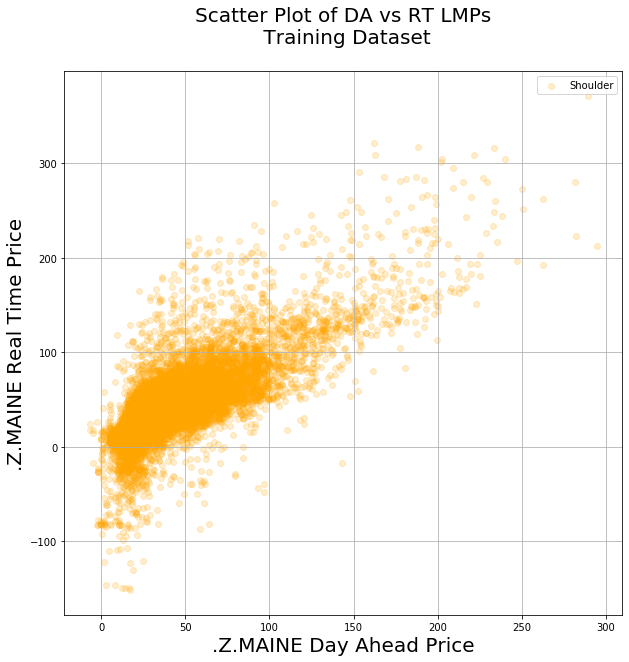

In [354]:
xpred = df_predict[da_lmp_label]
ypred = df_predict['Predicted RT LMP']

xtrain = df_train[da_lmp_label]
ytrain = df_train[rt_lmp_label]

xout = df_train[da_lmp_label]
yout = df_train[rt_lmp_label]

fig = plt.figure(figsize=(10, 10))

# plt.hist(dfLMP['DA LMP'],label='Real' +'DA LMP'+ ' distribution',alpha=0.5,density=True,color='b')

# plt.hist(dfModel['RT Gen MW'],label='Monte RT Gen MW',alpha=0.5,density=True,color='r')

plt.xlabel(da_lmp_label,fontsize = 20)
plt.ylabel(rt_lmp_label, fontsize = 20)

# plt.xlim(0, 350)
# plt.ylim(0, 500)
# plt.gca().set_aspect('equal', adjustable='box')

plt.title('Scatter Plot of DA vs RT LMPs\n Training Dataset\n' ,fontdict = {'fontsize' : 20})
plt.grid(True)

# plt.scatter(xsum,ysum,color='red',alpha=0.2,label='Summer')
# plt.scatter(xpred,ypred,color='b',alpha=0.2,label='Winter')
plt.scatter(xtrain,ytrain,color='orange',alpha=0.2,label='Shoulder')

plt.legend(loc='upper right')

In [326]:
# df_predict.to_excel('Latest Predicted RT LMPs 50 Sims Format1.xlsx')

In [ ]:
#This shows that 

In [63]:
#Run these functions first

In [96]:
def reject_outliers(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

In [97]:
def Fitting(y,bins = 51): 

    size = len(y)
    
    #Normalized Data
    y_std = (y-min(y))/(max(y)-min(y))
    
    dist_names = ['beta',
                  'lognorm',
                  'expon',
                  'norm',
                  'gamma']

    # Set up empty lists to stroe results
    chi_square = []
    p_values = []

    # Set up 50 bins for chi-square test
    # Observed data will be approximately evenly distrubuted aross all bins
    
    percentile_bins = np.linspace(0,100,bins)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
    
        # Obtain the KS test P statistic, round it to 5 decimal places
        p = scipy.stats.kstest(y_std, distribution, args=param)[1]
        p = np.around(p, 5)
        p_values.append(p)    
    
        # Get expected counts in percentile bins
        # This is based on a 'cumulative distrubution function' (cdf)
        cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                              scale=param[-1])
        expected_frequency = []
        
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)
    
        # calculate chi-squared
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
        chi_square.append(ss)
        
    # Collate results and sort by goodness of fit (best at top)

    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square
    results['p_value'] = p_values
    results.sort_values(['chi_square'], ascending = True ,inplace=True)
    
    # Report results

#    print ('\nDistributions sorted by goodness of fit:')
#    print ('----------------------------------------')
#    print (results)
    
    return results['Distribution'].iloc[0],y_std

In [98]:
def random_func(fitType,y,y_std,num=250):
            
    mu = y.mean()
    sigma = y.std()
    x = np.random.normal(mu, sigma,num)
    x = x[x<=np.amax(y)]
    x = x[x>=np.amin(y)]
        
    generated_random = list(x)
        

    
    return generated_random
    

In [99]:
def visual_check_fit(a,b,h,s):
    
    fig = plt.figure(figsize=(10, 7))
    
    plt.hist(a,label='Training Distribution',alpha=0.5,density=True,color='b')
    plt.hist(b,label='Fit Distribution',alpha=0.5,density=True,color='r')
    plt.legend(loc='upper right')
#     plt.xlabel(xname,fontsize = 20)
    plt.ylabel('Density', fontsize = 20)
    plt.title('Comparing Distributions\n'+ 'Hour: '+str(h) + 'Season: '+s +'\n',fontdict = {'fontsize' : 20})
    plt.grid(True)
#     fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

# Working Area

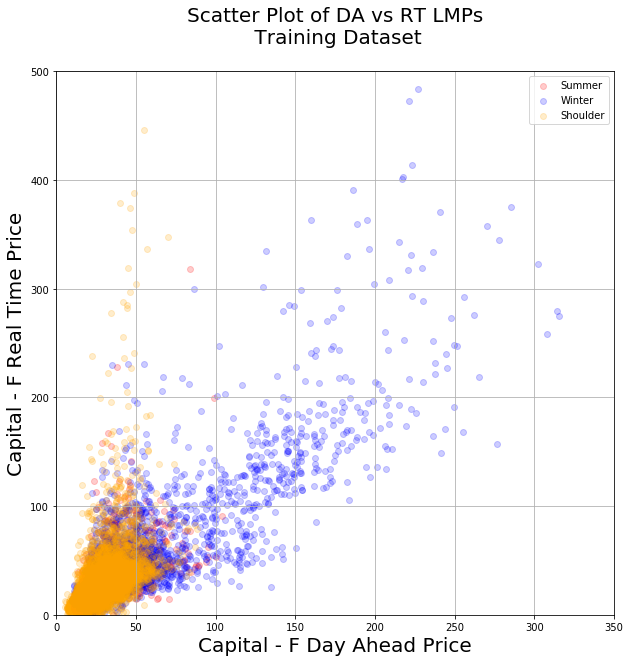

In [250]:
xsum = df_train[da_lmp_label][df_train.index.month.isin(summer)]
ysum = df_train[rt_lmp_label][df_train.index.month.isin(summer)]

xwin = df_train[da_lmp_label][df_train.index.month.isin(winter)]
ywin = df_train[rt_lmp_label][df_train.index.month.isin(winter)]

xsho = df_train[da_lmp_label][df_train.index.month.isin(shoulder)]
ysho = df_train[rt_lmp_label][df_train.index.month.isin(shoulder)]

fig = plt.figure(figsize=(10, 10))

# plt.hist(dfLMP['DA LMP'],label='Real' +'DA LMP'+ ' distribution',alpha=0.5,density=True,color='b')

# plt.hist(dfModel['RT Gen MW'],label='Monte RT Gen MW',alpha=0.5,density=True,color='r')

plt.xlabel(da_lmp_label,fontsize = 20)
plt.ylabel(rt_lmp_label, fontsize = 20)

plt.xlim(0, 350)
plt.ylim(0, 500)
# plt.gca().set_aspect('equal', adjustable='box')

plt.title('Scatter Plot of DA vs RT LMPs\n Training Dataset\n' ,fontdict = {'fontsize' : 20})
plt.grid(True)

plt.scatter(xsum,ysum,color='red',alpha=0.2,label='Summer')
plt.scatter(xwin,ywin,color='b',alpha=0.2,label='Winter')
plt.scatter(xsho,ysho,color='orange',alpha=0.2,label='Shoulder')

plt.legend(loc='upper right')

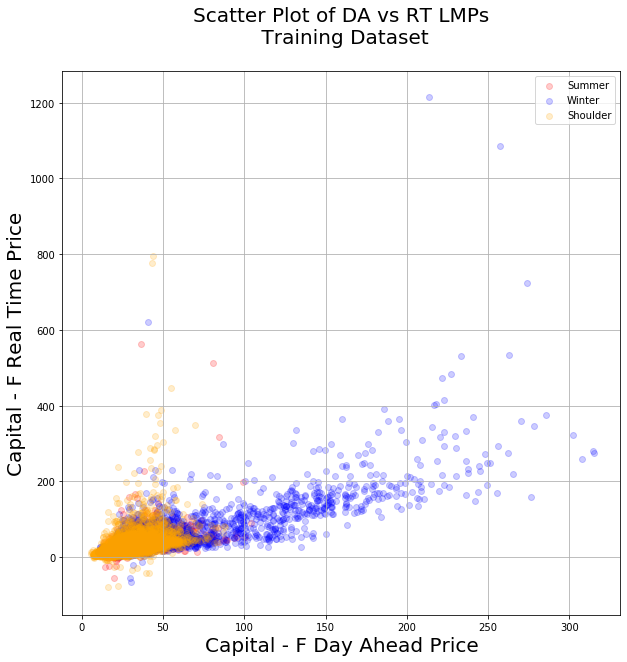

In [260]:
xsum = df_train[da_lmp_label][df_train.index.month.isin(summer)]
ysum = df_train[rt_lmp_label][df_train.index.month.isin(summer)]

xwin = df_train[da_lmp_label][df_train.index.month.isin(winter)]
ywin = df_train[rt_lmp_label][df_train.index.month.isin(winter)]

xsho = df_train[da_lmp_label][df_train.index.month.isin(shoulder)]
ysho = df_train[rt_lmp_label][df_train.index.month.isin(shoulder)]

fig = plt.figure(figsize=(10, 10))

# plt.hist(dfLMP['DA LMP'],label='Real' +'DA LMP'+ ' distribution',alpha=0.5,density=True,color='b')

# plt.hist(dfModel['RT Gen MW'],label='Monte RT Gen MW',alpha=0.5,density=True,color='r')

plt.xlabel(da_lmp_label,fontsize = 20)
plt.ylabel(rt_lmp_label, fontsize = 20)

# plt.xlim(0, 350)
# plt.ylim(0, 500)
# plt.gca().set_aspect('equal', adjustable='box')

plt.title('Scatter Plot of DA vs RT LMPs\n Training Dataset\n' ,fontdict = {'fontsize' : 20})
plt.grid(True)

plt.scatter(xsum,ysum,color='red',alpha=0.2,label='Summer')
plt.scatter(xwin,ywin,color='b',alpha=0.2,label='Winter')
plt.scatter(xsho,ysho,color='orange',alpha=0.2,label='Shoulder')

plt.legend(loc='upper right')

R square: 0.3122727177015001
intercept: [-2.1062131]
slope: [[0.02742253 0.55599284 0.89034092]]
coefficients of Hour, Month and DA_LMP:  [[0.02742253 0.55599284 0.89034092]]


{'whiskers': [<matplotlib.lines.Line2D at 0x200fc27cec8>,
 'caps': [<matplotlib.lines.Line2D at 0x200f4ec4a08>,
 'boxes': [<matplotlib.lines.Line2D at 0x200f89b8cc8>],
 'medians': [<matplotlib.lines.Line2D at 0x200fd29d788>],
 'fliers': [<matplotlib.lines.Line2D at 0x200f8250208>],
 'means': []}

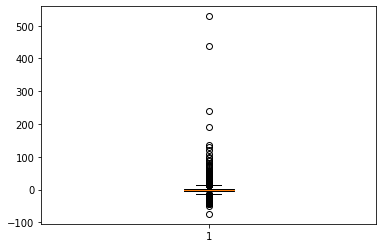

In [270]:
input_array_sum = df_train[["Hour Beginning", "Month",da_lmp_label]][df_train.index.month.isin(summer)].to_numpy()
output_array_sum = df_train[[rt_lmp_label]][df_train.index.month.isin(summer)].to_numpy()

model_sum = LinearRegression().fit(input_array_sum, output_array_sum)

#Get Results
r_sq = model_sum.score(input_array_sum, output_array_sum)
print('R square:', r_sq)
print('intercept:', model_sum.intercept_)
print('slope:', model_sum.coef_)

print('coefficients of Hour, Month and DA_LMP: ',model_sum.coef_)


preds_sum = model_sum.predict(input_array_sum)
residuals_sum = output_array_sum - preds_sum

plt.boxplot(residuals_sum)

R square: 0.6358488894244975
intercept: [-4.36644083]
slope: [[-0.08178014  0.20286529  1.10178839]]
coefficients of Hour, Month and DA_LMP:  [[-0.08178014  0.20286529  1.10178839]]


{'whiskers': [<matplotlib.lines.Line2D at 0x200f96c9488>,
 'caps': [<matplotlib.lines.Line2D at 0x200f8078388>,
 'boxes': [<matplotlib.lines.Line2D at 0x200fc028508>],
 'medians': [<matplotlib.lines.Line2D at 0x200fc4f0988>],
 'fliers': [<matplotlib.lines.Line2D at 0x200fc023d48>],
 'means': []}

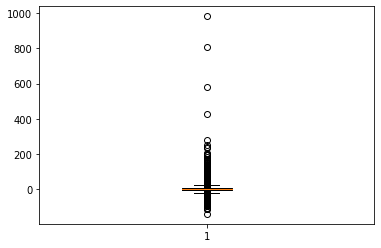

In [271]:
input_array_win = df_train[["Hour Beginning", "Month",da_lmp_label]][df_train.index.month.isin(winter)].to_numpy()
output_array_win = df_train[[rt_lmp_label]][df_train.index.month.isin(winter)].to_numpy()

model_win = LinearRegression().fit(input_array_win, output_array_win)

#Get Results
r_sq = model_win.score(input_array_win, output_array_win)
print('R square:', r_sq)
print('intercept:', model_win.intercept_)
print('slope:', model_win.coef_)

print('coefficients of Hour, Month and DA_LMP: ',model_win.coef_)


preds_win = model_win.predict(input_array_win)
residuals_win = output_array_win - preds_win

plt.boxplot(residuals_win)

R square: 0.23888888818846044
intercept: [-2.56123888]
slope: [[0.02748807 0.18991159 1.03197166]]
coefficients of Hour, Month and DA_LMP:  [[0.02748807 0.18991159 1.03197166]]


{'whiskers': [<matplotlib.lines.Line2D at 0x2008c49ce08>,
 'caps': [<matplotlib.lines.Line2D at 0x2008c49c4c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x200fc4f4248>],
 'medians': [<matplotlib.lines.Line2D at 0x200888367c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x200fc23be88>],
 'means': []}

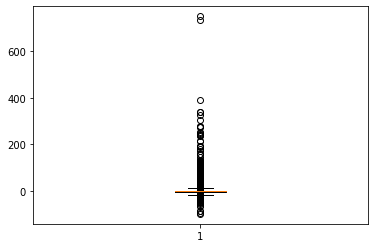

In [272]:
input_array_sho = df_train[["Hour Beginning", "Month",da_lmp_label]][df_train.index.month.isin(shoulder)].to_numpy()
output_array_sho = df_train[[rt_lmp_label]][df_train.index.month.isin(shoulder)].to_numpy()

model_sho = LinearRegression().fit(input_array_sho, output_array_sho)

#Get Results
r_sq = model_sho.score(input_array_sho, output_array_sho)
print('R square:', r_sq)
print('intercept:', model_sho.intercept_)
print('slope:', model_sho.coef_)

print('coefficients of Hour, Month and DA_LMP: ',model_sho.coef_)


preds_sho = model_sho.predict(input_array_sho)
residuals_sho = output_array_sho - preds_sho

plt.boxplot(residuals_sho)

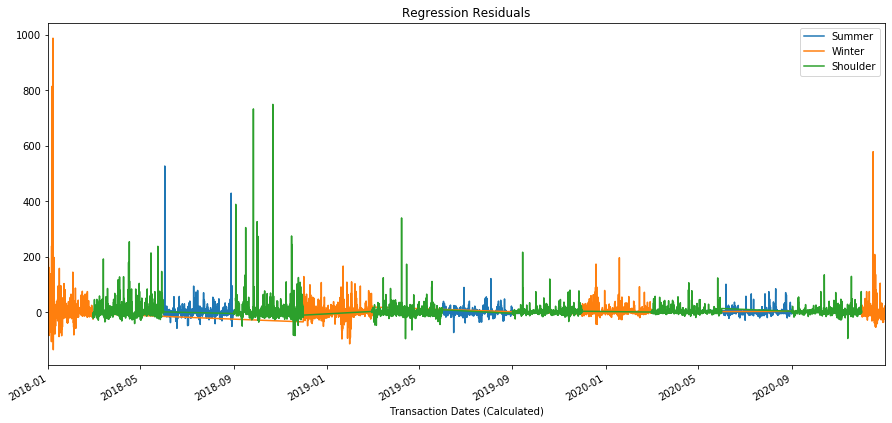

In [281]:
fig = plt.figure(figsize=(15, 7))
df_train['Residuals'][df_train.index.month.isin(summer)].plot(label='Summer')

df_train['Residuals'][df_train.index.month.isin(winter)].plot(label='Winter')

df_train['Residuals'][df_train.index.month.isin(shoulder)].plot(label='Shoulder')

plt.title('Regression Residuals')
plt.legend(loc='upper right')

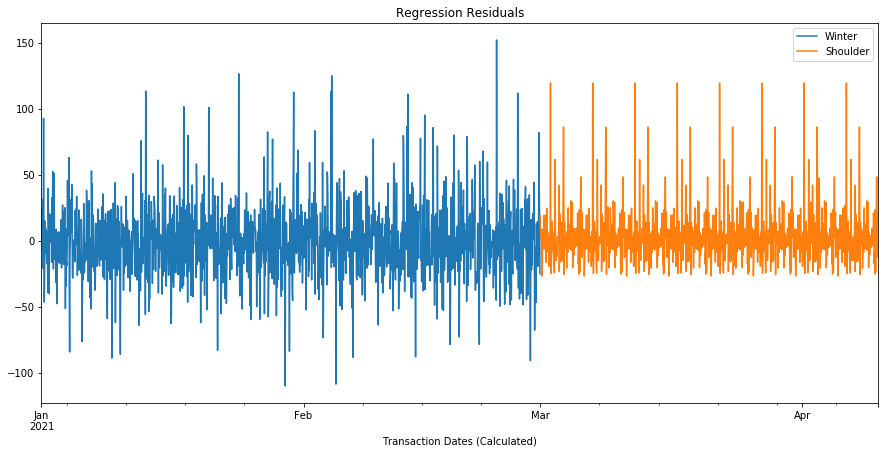

In [285]:
fig = plt.figure(figsize=(15, 7))
# df_test['Residual'][df_test.index.month.isin(summer)].plot(label='Summer')

df_test['Residual'][df_test.index.month.isin(winter)].plot(label='Winter')

df_test['Residual'][df_test.index.month.isin(shoulder)].plot(label='Shoulder')

plt.title('Regression Residuals')
plt.legend(loc='upper right')